# Load in Data

In [1]:
from formulas import *
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

keras = tf.keras

### Update Data
To update the SPY.csv data uncomment all the lines of the cell below and rerun. If enough time has passed, you may want to look at changing the splits of the validation data, test data, and the train data.

In [2]:
import yfinance as yf

spy = yf.Ticker("SPY")

# get stock info
spy.info

# get historical market data as df
hist = spy.history(period="max")

# Save df as CSV
hist.to_csv('SPY.CSV')

In [3]:
# Read data in to dataframes
spy = pd.read_csv('SPY.csv')
# dia = pd.read_csv('etfs/DIA.csv')
# qqq = pd.read_csv('etfs/QQQ.csv')


# Change date column to datetime type
spy['Date'] = pd.to_datetime(spy['Date'])
# dia['Date'] = pd.to_datetime(dia['Date'])
# qqq['Date'] = pd.to_datetime(qqq['Date'])

# # View amount of daily data
# print(f'There are {spy.shape[0]} rows in SPY and {dia.shape[0]} DIA rows')
# print('*'*100)
# print(f'''The date range of SPY is {spy.index.min()} to {spy.index.max()} 
#        \n DIA is {dia.index.values.min()} to {dia.index.max()}
#        \n QQQ is {qqq.index.min()} to {qqq.index.max()}''')

### SPY Train Test Split

Here we can see our complete plot in terms of time steps. Our entire data set is just shy of 7000 time steps. We know that our data is in days, so our data is just shy of 7000 daily observations. We need to separate out a training and validation set to see how our model holds up.

I will be choosing an arbitrary date to separate the training, validation, and test data.

In [4]:
series = spy['Close']

# Create train data set
train_split_date = '2014-12-31'
train_split_index = np.where(spy.Date == train_split_date)[0][0]
x_train = spy.loc[spy['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2019-01-02'
test_split_index = np.where(spy.Date == test_split_date)[0][0]
x_test = spy.loc[spy['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

5521 5522 6527 6528 6949


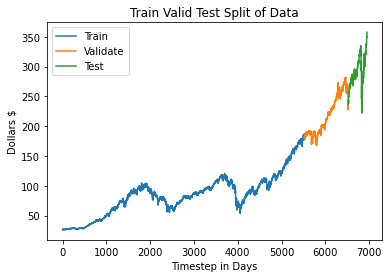

In [5]:
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [6]:
# Lets create a dictionary to store all of our model training scores to view later
model_mae_scores = {}

# Base Model - Naive Forecasting
A naive forecast is naive because it takes the price from the day before and uses that price for the prediction of tomorrow. This is suprisingly effecting in this scenario due to the extremely. 

Text(0.5, 1.0, 'Price History of SPY Jan-1993 to Sept-2020')

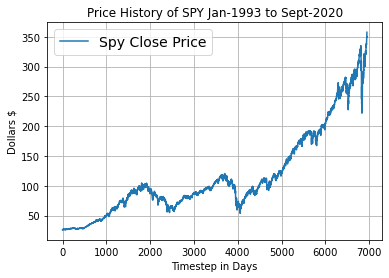

In [7]:
plot_series(time=spy.index,series=spy['Close'], label = 'Spy Close Price')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('Price History of SPY Jan-1993 to Sept-2020')

In [8]:
naive_forecast = series[test_split_index-1 :-1]

Text(0.5, 1.0, 'Naive Forecast vs Actual')

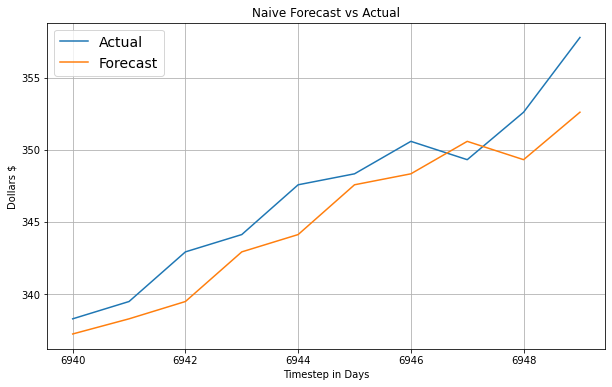

In [9]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index[-10:], x_test[-10:], label="Actual")
plot_series(x_test.index[-10:], naive_forecast[-10:], label="Forecast")
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('Naive Forecast vs Actual')

### Calculate Error in Naive Model

In [10]:
# Alternative way to show MAE to stay consistent with what we will be doing later
naive_forecast_mae = keras.metrics.mean_absolute_error(x_test, naive_forecast).numpy()
model_mae_scores['naive'] = naive_forecast_mae
model_mae_scores

{'naive': 2.722772511848341}

In [11]:
# Show first 3 values of our forecast
print(naive_forecast.values[:3])

# Show first 3 values of validation data
print(x_test.values[:3])

# Calculate and show first 3 values of the calculated error (MAE)
print('*'*100)
print(np.abs(naive_forecast[:3].values - x_test[:3].values))

[242.77 243.03 237.23]
[243.03 237.23 245.17]
****************************************************************************************************
[0.26 5.8  7.94]


### Add MAE score to our dictionary

In [12]:
model_mae_scores

{'naive': 2.722772511848341}

# Monthly Moving Average Model (20 Day MA)

Text(0.5, 1.0, 'SMA20 vs Actual')

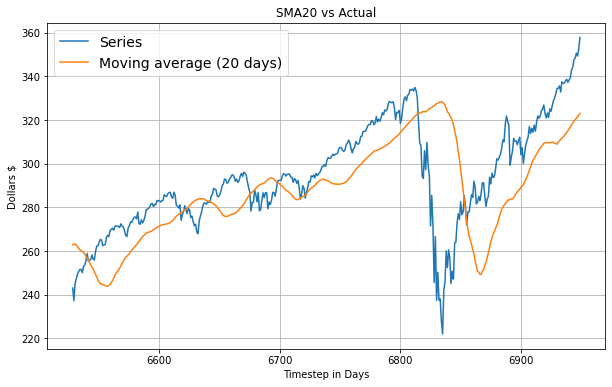

In [13]:
# Choose a window size for the moving average
window = 20

# Create a moving average over the entire dataset
moving_avg = spy['Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:spy.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (20 days)")
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('SMA20 vs Actual')

In [14]:
ma_20 = keras.metrics.mean_absolute_error(x_test, moving_avg_forecast).numpy()

model_mae_scores['SMA 20'] = ma_20
model_mae_scores

{'naive': 2.722772511848341, 'SMA 20': 16.962856635071123}

# Weekly Moving Average (5 day MA)

Text(0.5, 1.0, 'SMA5 Forecast vs Actual')

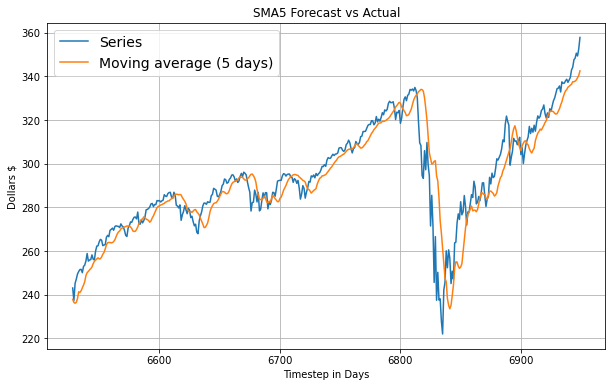

In [15]:
# Choose a window size for the moving average
window = 5

# Create a moving average over the entire dataset
moving_avg = spy['Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:spy.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (5 days)")
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('SMA5 Forecast vs Actual')

In [16]:
# Calculate MAE
ma_5 = keras.metrics.mean_absolute_error(x_test, moving_avg_forecast).numpy()

# Save to our dictionary of model mae scores
model_mae_scores['SMA 5'] = ma_5
model_mae_scores

{'naive': 2.722772511848341,
 'SMA 20': 16.962856635071123,
 'SMA 5': 6.754151658767568}

# ARIMA

### Step 1: Is the data stationary?

Use Augmented Dickey Fuller test to determine if the data is stationary
- Failure to reject the null hypothesis means the data is not stationary

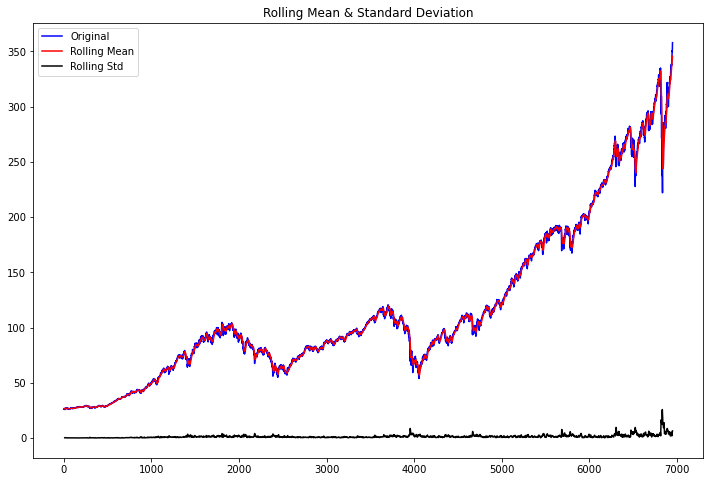

Results of Dickey-Fuller Test:
p-value = 0.9985. The series is likely non-stationary.
Test Statistic                    1.881042
p-value                           0.998497
#Lags Used                       20.000000
Number of Observations Used    6929.000000
Critical Value (1%)              -3.431294
Critical Value (5%)              -2.861957
Critical Value (10%)             -2.566992
dtype: float64


In [17]:
test_stationarity(series)

The **p-value is obtained is greater than significance level of 0.05** and the **ADF statistic is higher than any of the critical values.**

Clearly, there is no reason to reject the null hypothesis. **So, the time series is in fact non-stationary.** Since our data is not statio

### Step 2 Differencing
We must convert our non-stationary data to stationary data using the differencing method. This means we take the value at time (t) and subtract the value at time (t-1) to get the difference.

In [18]:
# Get the difference of each Adj Close point
spy_close_diff_1 = series.diff()
spy_close_diff_1.dropna(inplace=True)

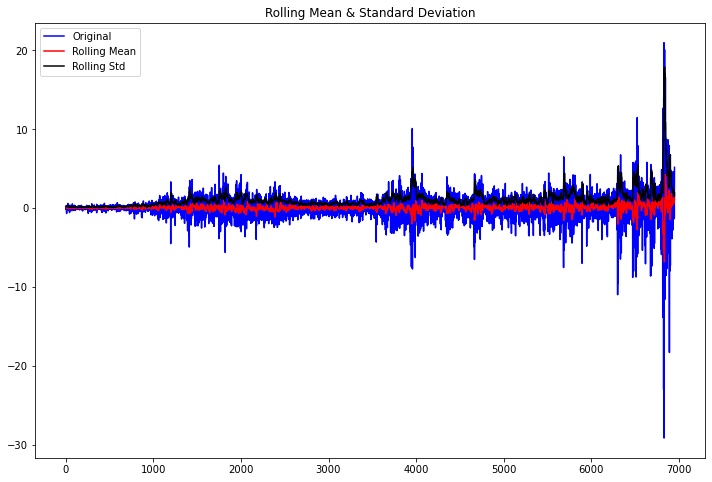

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.831861e+01
p-value                        2.268280e-30
#Lags Used                     1.900000e+01
Number of Observations Used    6.929000e+03
Critical Value (1%)           -3.431294e+00
Critical Value (5%)           -2.861957e+00
Critical Value (10%)          -2.566992e+00
dtype: float64


In [19]:
# Plot the spy Adj Close 1st order difference
test_stationarity(spy_close_diff_1)

The **p-value is obtained is less than significance level of 0.05** and the **ADF statistic is lower than any of the critical values.**

We reject the null hypothesis. **So, the time series is in fact stationary.** 

### Step 3 Autocorrelation and Partial autocorrelation

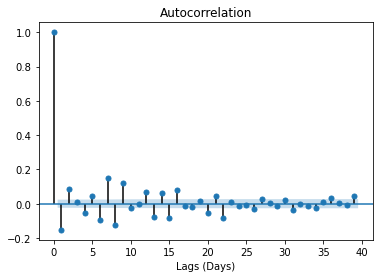

In [20]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(spy_close_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

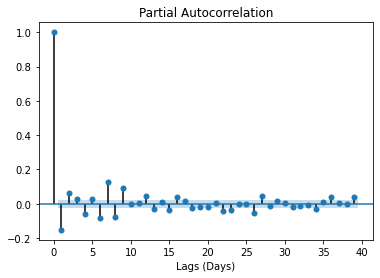

In [21]:
plot_pacf(spy_close_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

In [22]:
# Establish empty list for for-loop
spy_autocorr = []

# Loop through lag numbers to find the point with highest autocorrelation
for x in list(range(1,101)):
    spy_autocorr.append(spy_close_diff_1.autocorr(lag=x))

# Show the index of the point with the largest autocorrelation value
# 0 indexed so add 1 for correct number of lags
lags = spy_autocorr.index(max(spy_autocorr)) + 1 
print('The best performing lag is number {}'.format(lags))

The best performing lag is number 7


### Testing different arima models

In [23]:
from statsmodels.tsa.arima_model import ARIMA

# fit model
spy_arima = ARIMA(x_train, order=(1,1,1))
spy_arima_fit = spy_arima.fit(disp=0)
print(spy_arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 5521
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7864.841
Method:                       css-mle   S.D. of innovations              1.006
Date:                Wed, 02 Sep 2020   AIC                          15737.682
Time:                        15:14:08   BIC                          15764.148
Sample:                             1   HQIC                         15746.912
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0287      0.011      2.566      0.010       0.007       0.051
ar.L1.D.Close     0.6402      0.089      7.179      0.000       0.465       0.815
ma.L1.D.Close    -0.7027      0.083     

NormaltestResult(statistic=863.6353376774764, pvalue=2.910510933059743e-188)
This distribution is not a normal distribution


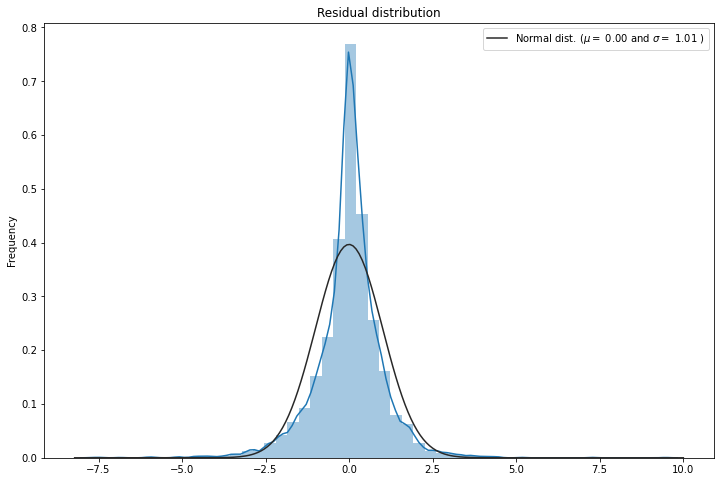

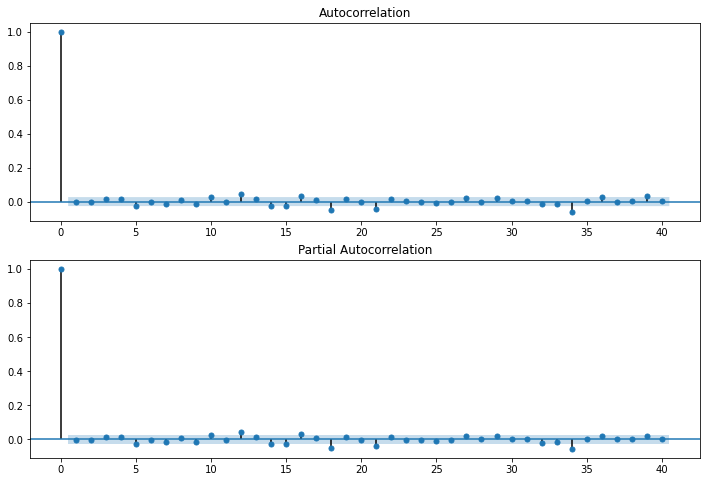

In [24]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = spy_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

### Step 4: Building the Arima Model and Forecasting

In [26]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

# loop through every data point
for time_point in list(x_test.index):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
MAE_error = keras.metrics.mean_absolute_error(x_test, model_predictions).numpy()
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

Testing Mean Squared Error is [108.75755952  55.2641297   58.44904657  49.30112582  46.66773325
  44.5935113   43.40951923  42.58986726  42.44610287  43.72076468
  41.48386763  40.71818716  39.14465336  36.31850823  38.78642649
  38.69075262  38.50139294  36.80876818  38.15064553  38.60791882
  35.47009163  33.40437044  33.15998382  31.81114838  30.86704831
  31.05002451  32.92496508  32.88227445  32.73127971  30.27700245
  29.41100967  29.79442015  27.8442851   27.32326853  26.9510391
  27.5504231   26.52246565  26.1677226   26.28131405  26.36579226
  26.70084291  25.68474623  26.1691507   26.48312943  27.57863266
  29.23130318  29.75785946  27.14072387  26.21157116  25.11501519
  25.10836362  24.37753221  23.76982434  23.68817682  24.13020692
  22.58968001  25.22716337  25.7115119   24.52344018  25.20801357
  24.725052    23.7240947   22.03748889  21.82921205  21.64923142
  21.31992108  20.7715737   20.64728026  21.18410466  20.8738878
  20.85947188  20.24905545  20.2423572   20.2045

In [27]:
# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

[array([184.5022509]),
 array([238.13209089]),
 array([234.90574724]),
 array([244.28651455]),
 array([247.0566748])]

In [28]:
#save model
model_fit.save('arima_111.pkl')

# Load model
from statsmodels.tsa.arima.model import ARIMAResults
loaded = ARIMAResults.load('arima_111.pkl')

In [29]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = keras.metrics.mean_absolute_error(x_test, model_predictions).numpy()

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA'] = arima_mae
model_mae_scores

{'naive': 2.722772511848341,
 'SMA 20': 16.962856635071123,
 'SMA 5': 6.754151658767568,
 'ARIMA': 2.795754057940963}

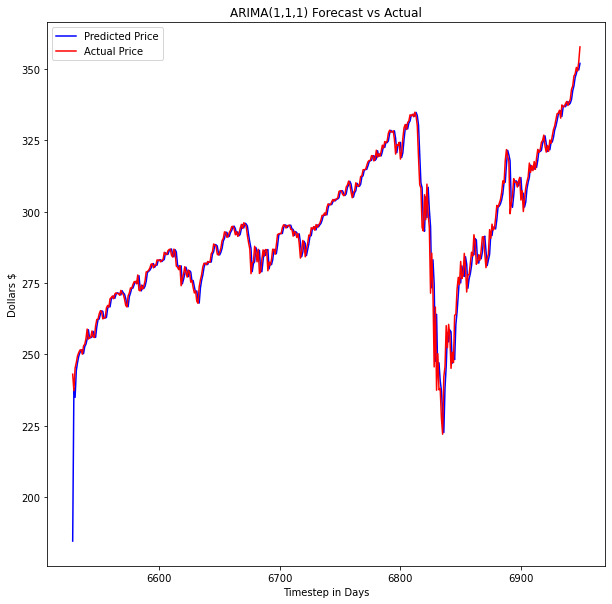

<Figure size 720x432 with 0 Axes>

In [30]:
plt.rcParams['figure.figsize'] = [10, 10]

plt.plot(x_test.index, model_predictions, color='blue',label='Predicted Price')
plt.plot(x_test.index, x_test, color='red', label='Actual Price')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(1,1,1) Forecast vs Actual')
# plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

In [31]:
# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

#### Show Error in model vs actual

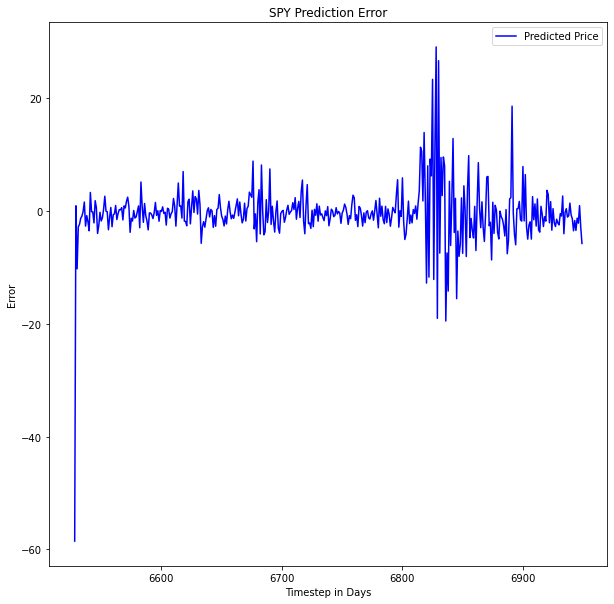

<Figure size 720x432 with 0 Axes>

In [32]:
plt.plot(x_test.index, arima_error, color='blue',label='Predicted Price')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('SPY Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Deep Learning

## Scale Data for Deep Learning Models

In [69]:
# Reshape values
x_train_values = x_train.values.reshape((len(x_train), 1))
x_valid_values = x_valid.values.reshape((len(x_valid), 1))
x_test_values = x_test.values.reshape((len(x_test), 1))
series_values = series.values.reshape((len(series), 1))

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.fit_transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.fit_transform(x_test_values)

# Fit x_valid values
normalized_series = x_valid_scaler.fit_transform(series_values)

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

## Single Dense Neuron Linear Model

#### Learning Rate Finder

In [70]:
# Clears any background saved info useful in notebooks
keras.backend.clear_session()

# Make reproducible 
tf.random.set_seed(42)
np.random.seed(42)

# set window size 
window_size = 20

# define training data (20 day windows shifted by 1 every time)
train_set = window_dataset(normalized_x_train.flatten(), window_size)

# Build Linear Model of a single dense layer
model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

# Find optimal learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.Nadam(lr=1e-6)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Fit the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
172/172 [==============================] - 1s 3ms/step - loss: 0.0479 - mae: 0.2662
Epoch 2/100
172/172 [==============================] - 0s 3ms/step - loss: 0.0473 - mae: 0.2646
Epoch 3/100
172/172 [==============================] - 1s 3ms/step - loss: 0.0469 - mae: 0.2632
Epoch 4/100
172/172 [==============================] - 0s 3ms/step - loss: 0.0464 - mae: 0.2617
Epoch 5/100
172/172 [==============================] - 0s 3ms/step - loss: 0.0458 - mae: 0.2602
Epoch 6/100
172/172 [==============================] - 0s 3ms/step - loss: 0.0453 - mae: 0.2585
Epoch 7/100
172/172 [==============================] - 1s 3ms/step - loss: 0.0447 - mae: 0.2567
Epoch 8/100
172/172 [==============================] - 0s 3ms/step - loss: 0.0440 - mae: 0.2548
Epoch 9/100
172/172 [==============================] - 0s 3ms/step - loss: 0.0433 - mae: 0.2528
Epoch 10/100
172/172 [==============================] - 0s 3ms/step - loss: 0.0426 - mae: 0.2506
Epoch 11/100
172/172 [=================

172/172 [==============================] - 0s 3ms/step - loss: 1.6919e-04 - mae: 0.0130
Epoch 84/100
172/172 [==============================] - 0s 3ms/step - loss: 1.6022e-04 - mae: 0.0126
Epoch 85/100
172/172 [==============================] - 0s 3ms/step - loss: 1.4963e-04 - mae: 0.0122
Epoch 86/100
172/172 [==============================] - 0s 3ms/step - loss: 1.4060e-04 - mae: 0.0118
Epoch 87/100
172/172 [==============================] - 0s 3ms/step - loss: 1.3102e-04 - mae: 0.0114
Epoch 88/100
172/172 [==============================] - 0s 3ms/step - loss: 1.2016e-04 - mae: 0.0109
Epoch 89/100
172/172 [==============================] - 1s 3ms/step - loss: 1.1105e-04 - mae: 0.0105
Epoch 90/100
172/172 [==============================] - 0s 3ms/step - loss: 1.0145e-04 - mae: 0.0100
Epoch 91/100
172/172 [==============================] - 0s 3ms/step - loss: 9.1897e-05 - mae: 0.0095
Epoch 92/100
172/172 [==============================] - 0s 3ms/step - loss: 8.4548e-05 - mae: 0.0091
Epo

(1e-06, 1.0, 0.0, 0.01)

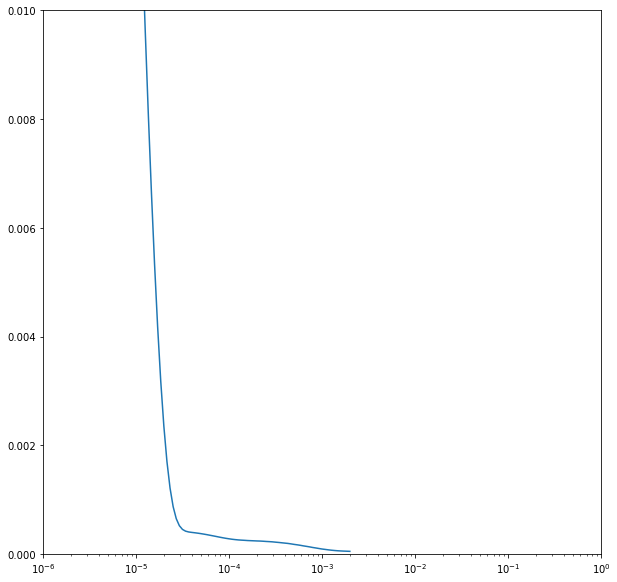

In [71]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1, 0, .01])

#### Train Model

In [72]:
# Useful to clear everything when rerunning cells
keras.backend.clear_session()

# Make this reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Create train and validate windows
window_size = 20
train_set = window_dataset(normalized_x_train.flatten(), window_size)
valid_set = window_dataset(normalized_x_valid.flatten(), window_size)

# 1 layer producing linear output for 1 output from each window of 20 days
model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

# Huber works well with "mae"
optimizer = keras.optimizers.Nadam(lr=1e-3)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# create save points for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# Set up early stop
early_stopping = keras.callbacks.EarlyStopping(patience=10)

# fit model to data
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
    135/Unknown - 0s 3ms/step - loss: 0.0102 - mae: 0.0884INFO:tensorflow:Assets written to: my_checkpoint\assets
172/172 [==============================] - 1s 5ms/step - loss: 0.0081 - mae: 0.0742 - val_loss: 0.0014 - val_mae: 0.0416
Epoch 2/500
172/172 [==============================] - 1s 5ms/step - loss: 4.0522e-04 - mae: 0.0221 - val_loss: 0.0011 - val_mae: 0.0348
Epoch 3/500
172/172 [==============================] - 1s 5ms/step - loss: 2.1834e-04 - mae: 0.0166 - val_loss: 8.6894e-04 - val_mae: 0.0303
Epoch 4/500
172/172 [==============================] - 1s 5ms/step - loss: 1.3198e-04 - mae: 0.0128 - val_loss: 7.9755e-04 - val_mae: 0.0285
Epoch 5/500
172/172 [==============================] - 1s 4ms/step - loss: 1.0304e-04 - mae: 0.0108 - val_loss: 7.7444e-04 - val_mae: 0.0280
Epoch 6/500
172/172 [==============================] - 1s 5ms/step - loss: 9.5140e-05 - mae: 0.0099 - val_loss: 7.5964e-04 - val_mae: 0.0275
Epoch 7/500
172/172 [==============================]

172/172 [==============================] - 1s 5ms/step - loss: 6.5590e-05 - mae: 0.0081 - val_loss: 5.0492e-04 - val_mae: 0.0223
Epoch 31/500
172/172 [==============================] - 1s 3ms/step - loss: 6.5712e-05 - mae: 0.0081 - val_loss: 5.3460e-04 - val_mae: 0.0228
Epoch 32/500
172/172 [==============================] - 1s 5ms/step - loss: 6.4349e-05 - mae: 0.0080 - val_loss: 4.9217e-04 - val_mae: 0.0222
Epoch 33/500
172/172 [==============================] - 1s 5ms/step - loss: 6.3652e-05 - mae: 0.0079 - val_loss: 4.7973e-04 - val_mae: 0.0217
Epoch 34/500
172/172 [==============================] - 1s 4ms/step - loss: 6.3537e-05 - mae: 0.0079 - val_loss: 4.7110e-04 - val_mae: 0.0216
Epoch 35/500
172/172 [==============================] - 1s 5ms/step - loss: 6.2020e-05 - mae: 0.0078 - val_loss: 4.6466e-04 - val_mae: 0.0213
Epoch 36/500
172/172 [==============================] - 1s 3ms/step - loss: 6.1077e-05 - mae: 0.0078 - val_loss: 4.6914e-04 - val_mae: 0.0219
Epoch 37/500
172/17

172/172 [==============================] - 1s 5ms/step - loss: 4.3868e-05 - mae: 0.0065 - val_loss: 3.2966e-04 - val_mae: 0.0178
Epoch 63/500
172/172 [==============================] - 1s 5ms/step - loss: 4.4104e-05 - mae: 0.0065 - val_loss: 3.2458e-04 - val_mae: 0.0177
Epoch 64/500
172/172 [==============================] - 1s 4ms/step - loss: 4.3207e-05 - mae: 0.0065 - val_loss: 3.2030e-04 - val_mae: 0.0178
Epoch 65/500
172/172 [==============================] - 1s 3ms/step - loss: 4.2644e-05 - mae: 0.0065 - val_loss: 3.2094e-04 - val_mae: 0.0175
Epoch 66/500
172/172 [==============================] - 1s 5ms/step - loss: 4.2327e-05 - mae: 0.0064 - val_loss: 3.1808e-04 - val_mae: 0.0174
Epoch 67/500
172/172 [==============================] - 1s 4ms/step - loss: 4.1518e-05 - mae: 0.0064 - val_loss: 3.2318e-04 - val_mae: 0.0183
Epoch 68/500
172/172 [==============================] - 1s 3ms/step - loss: 4.1861e-05 - mae: 0.0064 - val_loss: 3.3168e-04 - val_mae: 0.0188
Epoch 69/500
172/17

Epoch 97/500
172/172 [==============================] - 1s 5ms/step - loss: 3.3720e-05 - mae: 0.0057 - val_loss: 2.4206e-04 - val_mae: 0.0154
Epoch 98/500
172/172 [==============================] - 1s 4ms/step - loss: 3.3428e-05 - mae: 0.0057 - val_loss: 2.4828e-04 - val_mae: 0.0153
Epoch 99/500
172/172 [==============================] - 1s 5ms/step - loss: 3.3269e-05 - mae: 0.0057 - val_loss: 2.3860e-04 - val_mae: 0.0150
Epoch 100/500
172/172 [==============================] - 1s 5ms/step - loss: 3.2874e-05 - mae: 0.0056 - val_loss: 2.3647e-04 - val_mae: 0.0151
Epoch 101/500
172/172 [==============================] - 1s 4ms/step - loss: 3.2611e-05 - mae: 0.0056 - val_loss: 2.4000e-04 - val_mae: 0.0155
Epoch 102/500
172/172 [==============================] - 1s 5ms/step - loss: 3.2468e-05 - mae: 0.0056 - val_loss: 2.3421e-04 - val_mae: 0.0151
Epoch 103/500
172/172 [==============================] - 1s 5ms/step - loss: 3.2794e-05 - mae: 0.0057 - val_loss: 2.3256e-04 - val_mae: 0.0150
Ep

Epoch 134/500
172/172 [==============================] - 1s 5ms/step - loss: 2.8381e-05 - mae: 0.0052 - val_loss: 2.0144e-04 - val_mae: 0.0138
Epoch 135/500
172/172 [==============================] - 1s 3ms/step - loss: 2.8873e-05 - mae: 0.0053 - val_loss: 2.0302e-04 - val_mae: 0.0142
Epoch 136/500
172/172 [==============================] - 1s 5ms/step - loss: 2.8196e-05 - mae: 0.0052 - val_loss: 2.0017e-04 - val_mae: 0.0140
Epoch 137/500
172/172 [==============================] - 1s 5ms/step - loss: 2.8216e-05 - mae: 0.0052 - val_loss: 1.9875e-04 - val_mae: 0.0138
Epoch 138/500
172/172 [==============================] - 1s 5ms/step - loss: 2.8421e-05 - mae: 0.0053 - val_loss: 1.9787e-04 - val_mae: 0.0138
Epoch 139/500
172/172 [==============================] - 1s 3ms/step - loss: 2.7851e-05 - mae: 0.0052 - val_loss: 2.0453e-04 - val_mae: 0.0144
Epoch 140/500
172/172 [==============================] - 1s 4ms/step - loss: 2.8035e-05 - mae: 0.0053 - val_loss: 1.9666e-04 - val_mae: 0.0136

172/172 [==============================] - 1s 5ms/step - loss: 2.5979e-05 - mae: 0.0050 - val_loss: 1.7842e-04 - val_mae: 0.0130
Epoch 174/500
172/172 [==============================] - 1s 4ms/step - loss: 2.6600e-05 - mae: 0.0050 - val_loss: 1.7797e-04 - val_mae: 0.0130
Epoch 175/500
172/172 [==============================] - 1s 4ms/step - loss: 2.5316e-05 - mae: 0.0049 - val_loss: 1.7881e-04 - val_mae: 0.0129
Epoch 176/500
172/172 [==============================] - 1s 3ms/step - loss: 2.5499e-05 - mae: 0.0049 - val_loss: 1.7801e-04 - val_mae: 0.0129
Epoch 177/500
172/172 [==============================] - 1s 3ms/step - loss: 2.5451e-05 - mae: 0.0050 - val_loss: 1.7841e-04 - val_mae: 0.0132
Epoch 178/500
172/172 [==============================] - 1s 3ms/step - loss: 2.5812e-05 - mae: 0.0050 - val_loss: 1.7853e-04 - val_mae: 0.0129
Epoch 179/500
172/172 [==============================] - 1s 5ms/step - loss: 2.5712e-05 - mae: 0.0050 - val_loss: 1.7674e-04 - val_mae: 0.0129
Epoch 180/500

172/172 [==============================] - 1s 5ms/step - loss: 2.4669e-05 - mae: 0.0049 - val_loss: 1.6555e-04 - val_mae: 0.0124
Epoch 213/500
172/172 [==============================] - 1s 4ms/step - loss: 2.4142e-05 - mae: 0.0048 - val_loss: 1.6886e-04 - val_mae: 0.0125
Epoch 214/500
172/172 [==============================] - 1s 3ms/step - loss: 2.3985e-05 - mae: 0.0048 - val_loss: 1.6677e-04 - val_mae: 0.0127
Epoch 215/500
172/172 [==============================] - 1s 4ms/step - loss: 2.3853e-05 - mae: 0.0048 - val_loss: 1.6766e-04 - val_mae: 0.0127
Epoch 216/500
172/172 [==============================] - 1s 3ms/step - loss: 2.4184e-05 - mae: 0.0048 - val_loss: 1.6582e-04 - val_mae: 0.0126
Epoch 217/500
172/172 [==============================] - 1s 5ms/step - loss: 2.3788e-05 - mae: 0.0048 - val_loss: 1.6441e-04 - val_mae: 0.0124
Epoch 218/500
172/172 [==============================] - 1s 5ms/step - loss: 2.4030e-05 - mae: 0.0048 - val_loss: 1.6433e-04 - val_mae: 0.0124
Epoch 219/500

Epoch 255/500
172/172 [==============================] - 1s 3ms/step - loss: 2.3149e-05 - mae: 0.0047 - val_loss: 1.5768e-04 - val_mae: 0.0122
Epoch 256/500
172/172 [==============================] - 1s 3ms/step - loss: 2.4182e-05 - mae: 0.0048 - val_loss: 1.6093e-04 - val_mae: 0.0121
Epoch 257/500
172/172 [==============================] - 1s 5ms/step - loss: 2.2793e-05 - mae: 0.0047 - val_loss: 1.5728e-04 - val_mae: 0.0121
Epoch 258/500
172/172 [==============================] - 1s 4ms/step - loss: 2.2974e-05 - mae: 0.0047 - val_loss: 1.5663e-04 - val_mae: 0.0121
Epoch 259/500
172/172 [==============================] - 1s 4ms/step - loss: 2.3083e-05 - mae: 0.0047 - val_loss: 1.5767e-04 - val_mae: 0.0122
Epoch 260/500
172/172 [==============================] - 1s 4ms/step - loss: 2.2895e-05 - mae: 0.0047 - val_loss: 1.6532e-04 - val_mae: 0.0123
Epoch 261/500
172/172 [==============================] - 1s 5ms/step - loss: 2.2653e-05 - mae: 0.0046 - val_loss: 1.5655e-04 - val_mae: 0.0121

Epoch 299/500
172/172 [==============================] - 1s 3ms/step - loss: 2.2256e-05 - mae: 0.0046 - val_loss: 1.5707e-04 - val_mae: 0.0120
Epoch 300/500
172/172 [==============================] - 1s 4ms/step - loss: 2.2440e-05 - mae: 0.0046 - val_loss: 1.5993e-04 - val_mae: 0.0121
Epoch 301/500
172/172 [==============================] - 1s 3ms/step - loss: 2.2012e-05 - mae: 0.0046 - val_loss: 1.5382e-04 - val_mae: 0.0118
Epoch 302/500
172/172 [==============================] - 1s 3ms/step - loss: 2.2199e-05 - mae: 0.0046 - val_loss: 1.5882e-04 - val_mae: 0.0121
Epoch 303/500
172/172 [==============================] - 1s 3ms/step - loss: 2.2103e-05 - mae: 0.0046 - val_loss: 1.5783e-04 - val_mae: 0.0120
Epoch 304/500
172/172 [==============================] - 1s 3ms/step - loss: 2.2569e-05 - mae: 0.0046 - val_loss: 1.5454e-04 - val_mae: 0.0122
Epoch 305/500
172/172 [==============================] - 1s 4ms/step - loss: 2.2198e-05 - mae: 0.0046 - val_loss: 1.5125e-04 - val_mae: 0.0118

172/172 [==============================] - 1s 4ms/step - loss: 2.1629e-05 - mae: 0.0045 - val_loss: 1.4890e-04 - val_mae: 0.0116
Epoch 345/500
172/172 [==============================] - 1s 4ms/step - loss: 2.1958e-05 - mae: 0.0046 - val_loss: 1.4749e-04 - val_mae: 0.0116
Epoch 346/500
172/172 [==============================] - 1s 3ms/step - loss: 2.1501e-05 - mae: 0.0045 - val_loss: 1.4779e-04 - val_mae: 0.0116
Epoch 347/500
172/172 [==============================] - 1s 4ms/step - loss: 2.1411e-05 - mae: 0.0045 - val_loss: 1.5129e-04 - val_mae: 0.0120
Epoch 348/500
172/172 [==============================] - 1s 4ms/step - loss: 2.2174e-05 - mae: 0.0046 - val_loss: 1.4752e-04 - val_mae: 0.0116
Epoch 349/500
172/172 [==============================] - 1s 5ms/step - loss: 2.1866e-05 - mae: 0.0045 - val_loss: 1.4734e-04 - val_mae: 0.0116
Epoch 350/500
172/172 [==============================] - 1s 3ms/step - loss: 2.1787e-05 - mae: 0.0045 - val_loss: 1.4772e-04 - val_mae: 0.0116
Epoch 351/500

#### Make Predictions and Evaluate

In [73]:
lin_forecast = model_forecast(model, normalized_series.flatten()[x_test.index.min() - window_size:-1], window_size)[:, 0]

In [74]:
# Undo the scaling
lin_forecast = x_train_scaler.inverse_transform(lin_forecast.reshape(-1,1)).flatten()
lin_forecast.shape

(422,)

In [75]:
lin_mae = keras.metrics.mean_absolute_error(x_test, lin_forecast).numpy()
model_mae_scores['linear_model'] = lin_mae

Text(0.5, 1.0, 'Single Neuron Linear Model Forecast vs Actual')

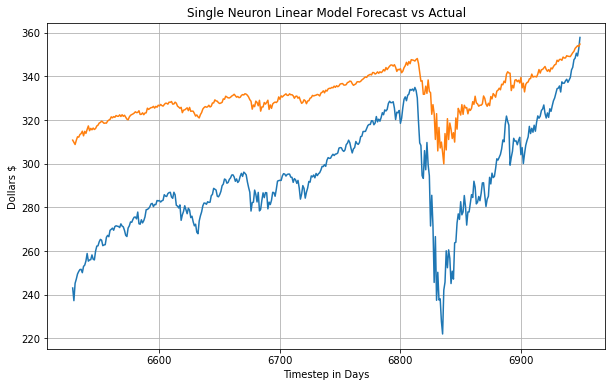

In [76]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test)
plot_series(x_test.index, lin_forecast)
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('Single Neuron Linear Model Forecast vs Actual')

## Dense Forecast

#### Learning Rate Finder

In [78]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = window_dataset(normalized_x_train.flatten(), window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.Nadam(lr=1e-7)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
172/172 [==============================] - 1s 3ms/step - loss: 0.2009 - mae: 0.5513
Epoch 2/100
172/172 [==============================] - 0s 3ms/step - loss: 0.2006 - mae: 0.5509
Epoch 3/100
172/172 [==============================] - 0s 3ms/step - loss: 0.2003 - mae: 0.5504
Epoch 4/100
172/172 [==============================] - 0s 3ms/step - loss: 0.2000 - mae: 0.5500
Epoch 5/100
172/172 [==============================] - 0s 3ms/step - loss: 0.1997 - mae: 0.5494
Epoch 6/100
172/172 [==============================] - 0s 3ms/step - loss: 0.1993 - mae: 0.5489
Epoch 7/100
172/172 [==============================] - 0s 3ms/step - loss: 0.1989 - mae: 0.5482
Epoch 8/100
172/172 [==============================] - 0s 3ms/step - loss: 0.1984 - mae: 0.5475
Epoch 9/100
172/172 [==============================] - 0s 3ms/step - loss: 0.1978 - mae: 0.5467
Epoch 10/100
172/172 [==============================] - 0s 3ms/step - loss: 0.1972 - mae: 0.5457
Epoch 11/100
172/172 [=================

172/172 [==============================] - 0s 3ms/step - loss: 6.0629e-05 - mae: 0.0078
Epoch 85/100
172/172 [==============================] - 0s 3ms/step - loss: 6.7031e-05 - mae: 0.0081
Epoch 86/100
172/172 [==============================] - 0s 3ms/step - loss: 7.4350e-05 - mae: 0.0084
Epoch 87/100
172/172 [==============================] - 0s 3ms/step - loss: 8.8454e-05 - mae: 0.0088
Epoch 88/100
172/172 [==============================] - 0s 3ms/step - loss: 8.4533e-05 - mae: 0.0090
Epoch 89/100
172/172 [==============================] - 0s 3ms/step - loss: 7.0914e-05 - mae: 0.0084
Epoch 90/100
172/172 [==============================] - 0s 3ms/step - loss: 1.1572e-04 - mae: 0.0096
Epoch 91/100
172/172 [==============================] - 0s 3ms/step - loss: 1.2413e-04 - mae: 0.0101
Epoch 92/100
172/172 [==============================] - 0s 3ms/step - loss: 1.5293e-04 - mae: 0.0107
Epoch 93/100
172/172 [==============================] - 0s 3ms/step - loss: 1.2931e-04 - mae: 0.0107
Epo

(1e-08, 1.0, 0.0, 0.01)

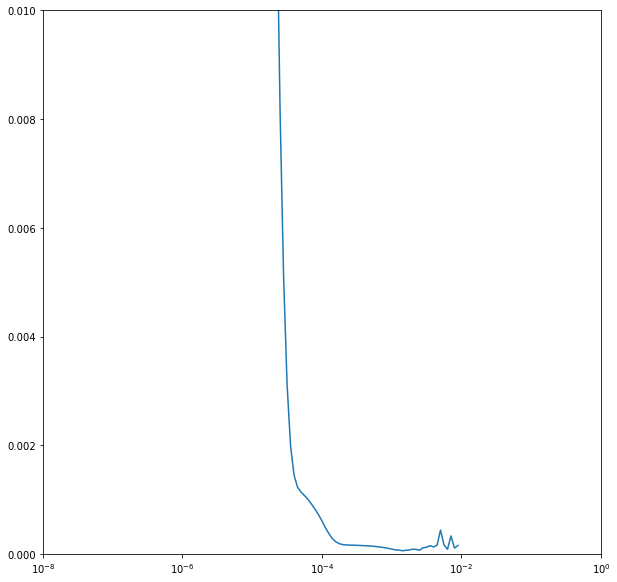

In [79]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1, 0, 0.01])

#### Train Model

In [80]:
# Clear back end
keras.backend.clear_session()

# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Set Window Size
window_size = 30
train_set = window_dataset(normalized_x_train.flatten(), window_size)
valid_set = window_dataset(normalized_x_valid.flatten(), window_size)

# Build 2 layer model with 10 neurons each and 1 output layer
model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

# Set optimizer
optimizer = keras.optimizers.Nadam(lr=1e-6)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Set early Stopping
early_stopping = keras.callbacks.EarlyStopping(patience=10)

# create save points for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# Fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
172/172 [==============================] - 1s 4ms/step - loss: 0.0687 - mae: 0.3201 - val_loss: 0.1091 - val_mae: 0.3978
Epoch 2/500
172/172 [==============================] - 1s 4ms/step - loss: 0.0671 - mae: 0.3160 - val_loss: 0.1070 - val_mae: 0.3938
Epoch 3/500
172/172 [==============================] - 1s 3ms/step - loss: 0.0658 - mae: 0.3126 - val_loss: 0.1050 - val_mae: 0.3900
Epoch 4/500
172/172 [==============================] - 1s 3ms/step - loss: 0.0645 - mae: 0.3094 - val_loss: 0.1031 - val_mae: 0.3863
Epoch 5/500
172/172 [==============================] - 1s 3ms/step - loss: 0.0632 - mae: 0.3061 - val_loss: 0.1013 - val_mae: 0.3827
Epoch 6/500
172/172 [==============================] - 1s 4ms/step - loss: 0.0620 - mae: 0.3030 - val_loss: 0.0995 - val_mae: 0.3791
Epoch 7/500
172/172 [==============================] - 1s 4ms/step - loss: 0.0608 - mae: 0.2999 - val_loss: 0.0977 - val_mae: 0.3755
Epoch 8/500
172/172 [==============================] - 1s 4ms/step - 

172/172 [==============================] - 1s 4ms/step - loss: 0.0165 - mae: 0.1509 - val_loss: 0.0296 - val_mae: 0.1998
Epoch 63/500
172/172 [==============================] - 1s 3ms/step - loss: 0.0160 - mae: 0.1487 - val_loss: 0.0288 - val_mae: 0.1971
Epoch 64/500
172/172 [==============================] - 1s 3ms/step - loss: 0.0156 - mae: 0.1465 - val_loss: 0.0281 - val_mae: 0.1945
Epoch 65/500
172/172 [==============================] - 1s 4ms/step - loss: 0.0152 - mae: 0.1443 - val_loss: 0.0274 - val_mae: 0.1919
Epoch 66/500
172/172 [==============================] - 1s 4ms/step - loss: 0.0147 - mae: 0.1422 - val_loss: 0.0267 - val_mae: 0.1894
Epoch 67/500
172/172 [==============================] - 1s 4ms/step - loss: 0.0143 - mae: 0.1401 - val_loss: 0.0261 - val_mae: 0.1869
Epoch 68/500
172/172 [==============================] - 1s 4ms/step - loss: 0.0139 - mae: 0.1380 - val_loss: 0.0254 - val_mae: 0.1844
Epoch 69/500
172/172 [==============================] - 1s 4ms/step - loss:

172/172 [==============================] - 1s 4ms/step - loss: 0.0014 - mae: 0.0404 - val_loss: 0.0041 - val_mae: 0.0710
Epoch 124/500
172/172 [==============================] - 1s 4ms/step - loss: 0.0014 - mae: 0.0394 - val_loss: 0.0040 - val_mae: 0.0698
Epoch 125/500
172/172 [==============================] - 1s 3ms/step - loss: 0.0013 - mae: 0.0385 - val_loss: 0.0038 - val_mae: 0.0686
Epoch 126/500
172/172 [==============================] - 1s 4ms/step - loss: 0.0012 - mae: 0.0375 - val_loss: 0.0037 - val_mae: 0.0674
Epoch 127/500
172/172 [==============================] - 1s 3ms/step - loss: 0.0012 - mae: 0.0367 - val_loss: 0.0036 - val_mae: 0.0662
Epoch 128/500
172/172 [==============================] - 1s 4ms/step - loss: 0.0011 - mae: 0.0359 - val_loss: 0.0034 - val_mae: 0.0651
Epoch 129/500
172/172 [==============================] - 1s 4ms/step - loss: 0.0011 - mae: 0.0351 - val_loss: 0.0033 - val_mae: 0.0641
Epoch 130/500
172/172 [==============================] - 1s 4ms/step 

172/172 [==============================] - 1s 4ms/step - loss: 3.9710e-04 - mae: 0.0226 - val_loss: 0.0015 - val_mae: 0.0438
Epoch 183/500
172/172 [==============================] - 1s 3ms/step - loss: 3.9416e-04 - mae: 0.0225 - val_loss: 0.0015 - val_mae: 0.0437
Epoch 184/500
172/172 [==============================] - 1s 4ms/step - loss: 3.9111e-04 - mae: 0.0224 - val_loss: 0.0015 - val_mae: 0.0436
Epoch 185/500
172/172 [==============================] - 1s 4ms/step - loss: 3.8841e-04 - mae: 0.0223 - val_loss: 0.0015 - val_mae: 0.0435
Epoch 186/500
172/172 [==============================] - 1s 3ms/step - loss: 3.8546e-04 - mae: 0.0222 - val_loss: 0.0015 - val_mae: 0.0434
Epoch 187/500
172/172 [==============================] - 1s 4ms/step - loss: 3.8285e-04 - mae: 0.0222 - val_loss: 0.0015 - val_mae: 0.0433
Epoch 188/500
172/172 [==============================] - 1s 3ms/step - loss: 3.7999e-04 - mae: 0.0221 - val_loss: 0.0015 - val_mae: 0.0432
Epoch 189/500
172/172 [==================

172/172 [==============================] - 1s 4ms/step - loss: 2.6780e-04 - mae: 0.0182 - val_loss: 0.0013 - val_mae: 0.0399
Epoch 242/500
172/172 [==============================] - 1s 4ms/step - loss: 2.6620e-04 - mae: 0.0182 - val_loss: 0.0013 - val_mae: 0.0398
Epoch 243/500
172/172 [==============================] - 1s 4ms/step - loss: 2.6461e-04 - mae: 0.0181 - val_loss: 0.0013 - val_mae: 0.0398
Epoch 244/500
172/172 [==============================] - 1s 4ms/step - loss: 2.6311e-04 - mae: 0.0180 - val_loss: 0.0013 - val_mae: 0.0397
Epoch 245/500
172/172 [==============================] - 1s 4ms/step - loss: 2.6151e-04 - mae: 0.0180 - val_loss: 0.0013 - val_mae: 0.0397
Epoch 246/500
172/172 [==============================] - 1s 4ms/step - loss: 2.5998e-04 - mae: 0.0179 - val_loss: 0.0013 - val_mae: 0.0396
Epoch 247/500
172/172 [==============================] - 1s 4ms/step - loss: 2.5839e-04 - mae: 0.0178 - val_loss: 0.0013 - val_mae: 0.0396
Epoch 248/500
172/172 [==================

172/172 [==============================] - 1s 4ms/step - loss: 1.9669e-04 - mae: 0.0149 - val_loss: 0.0011 - val_mae: 0.0374
Epoch 301/500
172/172 [==============================] - 1s 4ms/step - loss: 1.9579e-04 - mae: 0.0148 - val_loss: 0.0011 - val_mae: 0.0374
Epoch 302/500
172/172 [==============================] - 1s 4ms/step - loss: 1.9486e-04 - mae: 0.0148 - val_loss: 0.0011 - val_mae: 0.0373
Epoch 303/500
172/172 [==============================] - 1s 4ms/step - loss: 1.9387e-04 - mae: 0.0147 - val_loss: 0.0011 - val_mae: 0.0373
Epoch 304/500
172/172 [==============================] - 1s 4ms/step - loss: 1.9301e-04 - mae: 0.0147 - val_loss: 0.0011 - val_mae: 0.0372
Epoch 305/500
172/172 [==============================] - 1s 4ms/step - loss: 1.9214e-04 - mae: 0.0146 - val_loss: 0.0011 - val_mae: 0.0372
Epoch 306/500
172/172 [==============================] - 1s 4ms/step - loss: 1.9122e-04 - mae: 0.0146 - val_loss: 0.0011 - val_mae: 0.0371
Epoch 307/500
172/172 [==================

172/172 [==============================] - 1s 4ms/step - loss: 1.5558e-04 - mae: 0.0127 - val_loss: 0.0010 - val_mae: 0.0353
Epoch 360/500
172/172 [==============================] - 1s 4ms/step - loss: 1.5523e-04 - mae: 0.0126 - val_loss: 0.0010 - val_mae: 0.0353
Epoch 361/500
172/172 [==============================] - 1s 4ms/step - loss: 1.5476e-04 - mae: 0.0126 - val_loss: 0.0010 - val_mae: 0.0352
Epoch 362/500
172/172 [==============================] - 1s 4ms/step - loss: 1.5441e-04 - mae: 0.0126 - val_loss: 0.0010 - val_mae: 0.0352
Epoch 363/500
172/172 [==============================] - 1s 4ms/step - loss: 1.5390e-04 - mae: 0.0126 - val_loss: 0.0010 - val_mae: 0.0352
Epoch 364/500
172/172 [==============================] - 1s 4ms/step - loss: 1.5345e-04 - mae: 0.0126 - val_loss: 0.0010 - val_mae: 0.0351
Epoch 365/500
172/172 [==============================] - 1s 4ms/step - loss: 1.5306e-04 - mae: 0.0126 - val_loss: 0.0010 - val_mae: 0.0351
Epoch 366/500
172/172 [==================

Epoch 418/500
172/172 [==============================] - 1s 4ms/step - loss: 1.3853e-04 - mae: 0.0120 - val_loss: 9.9202e-04 - val_mae: 0.0338
Epoch 419/500
172/172 [==============================] - 1s 4ms/step - loss: 1.3831e-04 - mae: 0.0120 - val_loss: 9.9089e-04 - val_mae: 0.0337
Epoch 420/500
172/172 [==============================] - 1s 4ms/step - loss: 1.3820e-04 - mae: 0.0120 - val_loss: 9.9025e-04 - val_mae: 0.0337
Epoch 421/500
172/172 [==============================] - 1s 4ms/step - loss: 1.3802e-04 - mae: 0.0120 - val_loss: 9.8936e-04 - val_mae: 0.0337
Epoch 422/500
172/172 [==============================] - 1s 4ms/step - loss: 1.3777e-04 - mae: 0.0120 - val_loss: 9.8901e-04 - val_mae: 0.0337
Epoch 423/500
172/172 [==============================] - 1s 4ms/step - loss: 1.3763e-04 - mae: 0.0120 - val_loss: 9.8785e-04 - val_mae: 0.0337
Epoch 424/500
172/172 [==============================] - 1s 4ms/step - loss: 1.3740e-04 - mae: 0.0119 - val_loss: 9.8728e-04 - val_mae: 0.0336

172/172 [==============================] - 1s 4ms/step - loss: 1.3070e-04 - mae: 0.0117 - val_loss: 9.5277e-04 - val_mae: 0.0327
Epoch 476/500
172/172 [==============================] - 1s 4ms/step - loss: 1.3059e-04 - mae: 0.0116 - val_loss: 9.5222e-04 - val_mae: 0.0327
Epoch 477/500
172/172 [==============================] - 1s 4ms/step - loss: 1.3054e-04 - mae: 0.0116 - val_loss: 9.5144e-04 - val_mae: 0.0327
Epoch 478/500
172/172 [==============================] - 1s 4ms/step - loss: 1.3040e-04 - mae: 0.0116 - val_loss: 9.5101e-04 - val_mae: 0.0327
Epoch 479/500
172/172 [==============================] - 1s 3ms/step - loss: 1.3028e-04 - mae: 0.0116 - val_loss: 9.5055e-04 - val_mae: 0.0327
Epoch 480/500
172/172 [==============================] - 1s 4ms/step - loss: 1.3015e-04 - mae: 0.0116 - val_loss: 9.4993e-04 - val_mae: 0.0327
Epoch 481/500
172/172 [==============================] - 1s 3ms/step - loss: 1.3011e-04 - mae: 0.0116 - val_loss: 9.4931e-04 - val_mae: 0.0327
Epoch 482/500

#### Make Predictions and Evaluate

In [81]:
model = keras.models.load_model("my_checkpoint")

In [85]:
normalized_series.flatten().shape

(6950,)

In [83]:
dense_forecast = model_forecast(
    model,
    normalized_series[x_test.index.min() - window_size:-1],
    window_size)[:, 0]

ValueError: in user code:

    C:\Users\blake\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\blake\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\blake\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\blake\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\blake\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\blake\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\blake\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\blake\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\blake\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 20 but received input with shape [None, None, 1]


In [ ]:
# Undo the scaling
dense_forecast = x_train_scaler.inverse_transform(dense_forecast.reshape(-1,1)).flatten()
dense_forecast.shape

In [ ]:
dense_mae = keras.metrics.mean_absolute_error(x_test, dense_forecast).numpy()
model_mae_scores['dense'] = dense_mae

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test)
plot_series(x_test.index, dense_forecast)
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('Fully Dense Forecast vs Actual')

## Simple RNN Models

### Seq to Vec RNN Model 

#### Learning Rate

In [86]:
# Just to make sure nothing is hungup. I like to start clean.
keras.backend.clear_session()

# Set seeds so the model is reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Set your window size (days)
window_size = 100

# create windowed tensor data set from series
train_set = window_dataset(x_train, window_size, batch_size=512)

# Create RNN model
model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # Changes from 2D data to 3D (batch size, time, dimensionality per time step)
                      input_shape=[None]), # this  accepts windows of any shape
  
  keras.layers.SimpleRNN(100, return_sequences=True), # create RNN with 100 neurons
  keras.layers.SimpleRNN(100), # takes in sequence from previous layer outputs vector with 100 dimensions
  keras.layers.Dense(1), # Dense layer to make prediction
  ]) 

# Maps learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.Nadam(lr=1e-7)
model.compile(loss=keras.losses.Huber(),
              optimizer= optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=125, callbacks=[lr_schedule])


Epoch 1/125
11/11 [==============================] - 2s 176ms/step - loss: 84.5010 - mae: 85.0010
Epoch 2/125
11/11 [==============================] - 2s 173ms/step - loss: 84.4994 - mae: 84.9994
Epoch 3/125
11/11 [==============================] - 2s 175ms/step - loss: 84.4974 - mae: 84.9974
Epoch 4/125
11/11 [==============================] - 2s 171ms/step - loss: 84.4951 - mae: 84.9951
Epoch 5/125
11/11 [==============================] - 2s 176ms/step - loss: 84.4925 - mae: 84.9925
Epoch 6/125
11/11 [==============================] - 2s 178ms/step - loss: 84.4895 - mae: 84.9895
Epoch 7/125
11/11 [==============================] - 2s 173ms/step - loss: 84.4862 - mae: 84.9862
Epoch 8/125
11/11 [==============================] - 2s 173ms/step - loss: 84.4825 - mae: 84.9825
Epoch 9/125
11/11 [==============================] - 2s 172ms/step - loss: 84.4783 - mae: 84.9783
Epoch 10/125
11/11 [==============================] - 2s 173ms/step - loss: 84.4736 - mae: 84.9736
Epoch 11/125
11/11 

11/11 [==============================] - 2s 173ms/step - loss: 57.3207 - mae: 57.8151
Epoch 84/125
11/11 [==============================] - 2s 171ms/step - loss: 55.6846 - mae: 56.1754
Epoch 85/125
11/11 [==============================] - 2s 175ms/step - loss: 54.1067 - mae: 54.6052
Epoch 86/125
11/11 [==============================] - 2s 173ms/step - loss: 52.4376 - mae: 52.9363
Epoch 87/125
11/11 [==============================] - 2s 174ms/step - loss: 50.6479 - mae: 51.1463
Epoch 88/125
11/11 [==============================] - 2s 173ms/step - loss: 48.7408 - mae: 49.2383
Epoch 89/125
11/11 [==============================] - 2s 171ms/step - loss: 46.7070 - mae: 47.2052
Epoch 90/125
11/11 [==============================] - 2s 175ms/step - loss: 44.3948 - mae: 44.8925
Epoch 91/125
11/11 [==============================] - 2s 173ms/step - loss: 42.3677 - mae: 42.8641
Epoch 92/125
11/11 [==============================] - 2s 172ms/step - loss: 38.5980 - mae: 39.0958
Epoch 93/125
11/11 [===

(1e-07, 1.0, 0.0, 100.0)

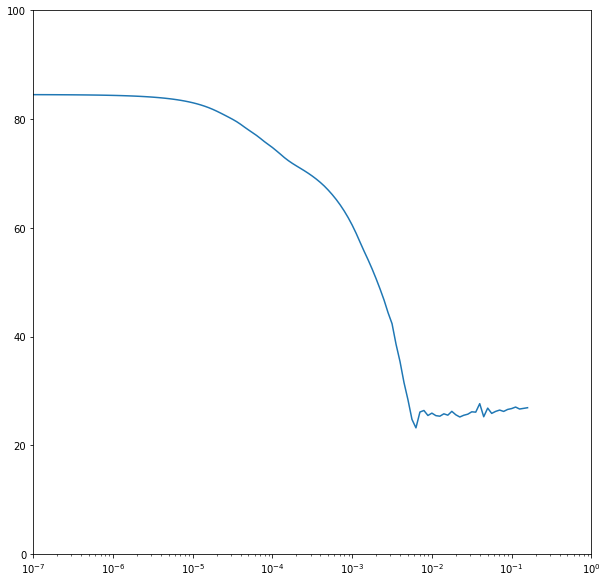

In [87]:
# Plot Learning Rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1, 0, 100])

#### Model Train

In [88]:
# Just to make sure nothing is hungup. I like to start clean.
keras.backend.clear_session()

# Set seeds so the model is reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Set your window size (days)
window_size = 20

# create windowed tensor data set from series
train_set = window_dataset(x_train, window_size, batch_size=512)
valid_set = window_dataset(x_valid, window_size, batch_size=512)


# Create RNN model
model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # Changes from 2D data to 3D (batch size, time, dimensionality per time step)
                      input_shape=[None]), # this  accepts windows of any shape
  keras.layers.SimpleRNN(100, return_sequences=True), # create RNN with 100 neurons
  keras.layers.SimpleRNN(100), # takes in sequence from previous layer outputs vector with 100 dimensions
  keras.layers.Dense(1), # Dense layer to make prediction
  ]) 

# # Set optimizer
optimizer = keras.optimizers.Nadam(lr=7e-3)

#compile model choose metric and loss function
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=10)

# create save points for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# fit model to data
model.fit(train_set, epochs=1000,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/1000
     11/Unknown - 1s 50ms/step - loss: 72.2486 - mae: 72.7486INFO:tensorflow:Assets written to: my_checkpoint\assets
11/11 [==============================] - 2s 212ms/step - loss: 72.2486 - mae: 72.7486 - val_loss: 200.6348 - val_mae: 201.1348
Epoch 2/1000
11/11 [==============================] - 2s 220ms/step - loss: 63.0356 - mae: 63.5356 - val_loss: 193.1898 - val_mae: 193.6898
Epoch 3/1000
11/11 [==============================] - 2s 198ms/step - loss: 55.5089 - mae: 56.0059 - val_loss: 185.5229 - val_mae: 186.0229
Epoch 4/1000
11/11 [==============================] - 2s 197ms/step - loss: 49.5651 - mae: 50.0637 - val_loss: 178.7007 - val_mae: 179.2007
Epoch 5/1000
11/11 [==============================] - 2s 223ms/step - loss: 44.6188 - mae: 45.1174 - val_loss: 172.2433 - val_mae: 172.7433
Epoch 6/1000
11/11 [==============================] - 2s 196ms/step - loss: 40.4618 - mae: 40.9614 - val_loss: 166.2434 - val_mae: 166.7434
Epoch 7/1000
11/11 [=======================

11/11 [==============================] - 2s 196ms/step - loss: 19.0239 - mae: 19.5152 - val_loss: 124.7799 - val_mae: 125.2799
Epoch 37/1000
11/11 [==============================] - 2s 199ms/step - loss: 19.0084 - mae: 19.4979 - val_loss: 124.2730 - val_mae: 124.7730
Epoch 38/1000
11/11 [==============================] - 3s 231ms/step - loss: 18.6607 - mae: 19.1491 - val_loss: 123.3945 - val_mae: 123.8945
Epoch 39/1000
11/11 [==============================] - 2s 198ms/step - loss: 18.7825 - mae: 19.2722 - val_loss: 122.8470 - val_mae: 123.3470
Epoch 40/1000
11/11 [==============================] - 2s 198ms/step - loss: 18.3679 - mae: 18.8604 - val_loss: 122.3032 - val_mae: 122.8032
Epoch 41/1000
11/11 [==============================] - 1s 61ms/step - loss: 18.4872 - mae: 18.9767 - val_loss: 123.8038 - val_mae: 124.3038
Epoch 42/1000
11/11 [==============================] - 1s 62ms/step - loss: 18.3357 - mae: 18.8247 - val_loss: 123.0461 - val_mae: 123.5461
Epoch 43/1000
11/11 [========

#### Make Predictions and Evaluate

In [89]:
model = keras.models.load_model("my_checkpoint")

In [90]:
rnn_seqtovec_forecast = model_forecast(
    model,
    normalized_series[x_test.index.min() - window_size:-1],
    window_size)[:, 0]

In [91]:
# Undo the scaling
rnn_seqtovec_forecast = x_train_scaler.inverse_transform(rnn_seqtovec_forecast.reshape(-1,1)).flatten()
rnn_seqtovec_forecast.shape

(422,)

Text(0.5, 1.0, 'RNN Forecast vs Actual')

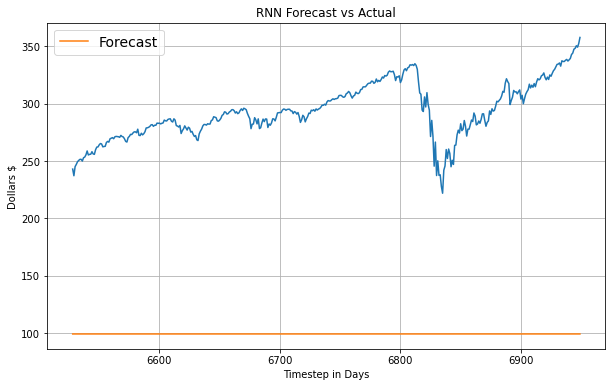

In [92]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test)
plot_series(x_test.index, rnn_seqtovec_forecast, label = 'Forecast')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('RNN Forecast vs Actual')


In [132]:
rnn_seqtovec_forecast_mae = keras.metrics.mean_absolute_error(x_test, rnn_seqtovec_forecast).numpy()
rnn_seqtovec_forecast_mae

model_mae_scores['rnn_seqtovec'] = rnn_seqtovec_forecast_mae
model_mae_scores

{'naive': 2.722772511848341,
 'SMA 20': 16.962856635071123,
 'SMA 5': 6.754151658767568,
 'ARIMA': 2.795754057940963,
 'linear_model': 37.513725,
 'rnn_seqtovec': 3008.7556,
 'rnn_seqtoseq': 41.524616,
 'lstm': 3.585236,
 'cnn_preprocessing_rnn': 38.362865,
 'full_cnn': 37.910133}

### Seq to Seq RNN

#### Learning Rate Finder

In [94]:
# Just to make sure nothing is hungup. I like to start clean.
keras.backend.clear_session()

# Set seeds so the model is reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Set your window size (days)
window_size = 100

# create windowed tensor data set from series
train_set = window_dataset(normalized_x_train, window_size, batch_size=512)

# Create RNN model
model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
])


# Maps learning rate
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))

optimizer = keras.optimizers.Nadam(lr=1e-7)


model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
11/11 [==============================] - 2s 206ms/step - loss: 0.0990 - mae: 0.3702
Epoch 2/100
11/11 [==============================] - 2s 212ms/step - loss: 0.0637 - mae: 0.2783
Epoch 3/100
11/11 [==============================] - 2s 212ms/step - loss: 0.0426 - mae: 0.2113
Epoch 4/100
11/11 [==============================] - 2s 209ms/step - loss: 0.0321 - mae: 0.1764
Epoch 5/100
11/11 [==============================] - 2s 209ms/step - loss: 0.0264 - mae: 0.1591
Epoch 6/100
11/11 [==============================] - 2s 213ms/step - loss: 0.0216 - mae: 0.1413
Epoch 7/100
11/11 [==============================] - 2s 207ms/step - loss: 0.0175 - mae: 0.1240
Epoch 8/100
11/11 [==============================] - 2s 208ms/step - loss: 0.0145 - mae: 0.1132
Epoch 9/100
11/11 [==============================] - 2s 209ms/step - loss: 0.0122 - mae: 0.1054
Epoch 10/100
11/11 [==============================] - 2s 210ms/step - loss: 0.0104 - mae: 0.0980
Epoch 11/100
11/11 [===================

11/11 [==============================] - 2s 213ms/step - loss: 7.8503 - mae: 8.3503
Epoch 86/100
11/11 [==============================] - 2s 212ms/step - loss: 8.5295 - mae: 9.0295
Epoch 87/100
11/11 [==============================] - 2s 215ms/step - loss: 9.3821 - mae: 9.8821
Epoch 88/100
11/11 [==============================] - 2s 213ms/step - loss: 10.2319 - mae: 10.7319
Epoch 89/100
11/11 [==============================] - 2s 215ms/step - loss: 11.3160 - mae: 11.8160
Epoch 90/100
11/11 [==============================] - 2s 212ms/step - loss: 12.4181 - mae: 12.9181
Epoch 91/100
11/11 [==============================] - 2s 211ms/step - loss: 13.6932 - mae: 14.1932
Epoch 92/100
11/11 [==============================] - 2s 214ms/step - loss: 15.1023 - mae: 15.6023
Epoch 93/100
11/11 [==============================] - 2s 214ms/step - loss: 16.6435 - mae: 17.1435
Epoch 94/100
11/11 [==============================] - 2s 211ms/step - loss: 18.4771 - mae: 18.9771
Epoch 95/100
11/11 [=========

(1e-07, 1.0, 0.0, 0.05)

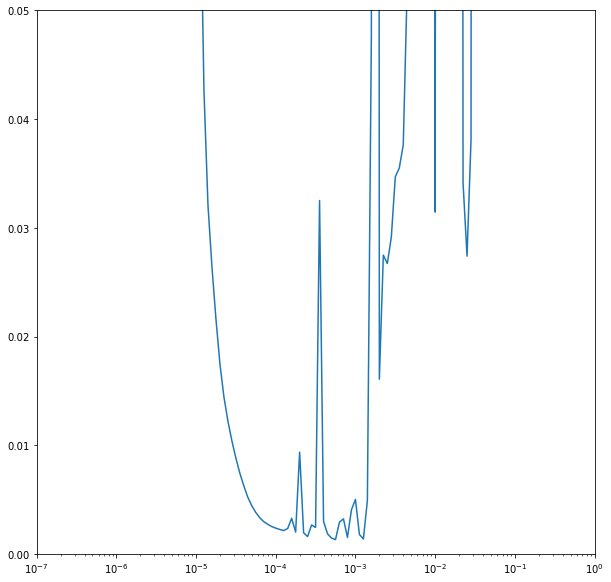

In [95]:
# Plot Learning Rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1, 0, .05])

#### Train Model

In [96]:
# Just to make sure nothing is hungup. I like to start clean.
keras.backend.clear_session()

# Set seeds so the model is reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Set your window size (days)
window_size = 100
train_set = window_dataset(normalized_x_train, window_size, batch_size=512)
valid_set = window_dataset(normalized_x_valid, window_size, batch_size=512)


# Create RNN model
model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
])

# Set optimizer
optimizer = keras.optimizers.Nadam(lr=1e-4)

#compile model choose metric and loss function
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=20)

# create save points for best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

# fit model to data
model.fit(train_set, epochs=1000,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/1000
     11/Unknown - 2s 203ms/step - loss: 0.0547 - mae: 0.2303INFO:tensorflow:Assets written to: my_checkpoint\assets
11/11 [==============================] - 4s 405ms/step - loss: 0.0547 - mae: 0.2303 - val_loss: 0.0584 - val_mae: 0.2711
Epoch 2/1000
11/11 [==============================] - 4s 365ms/step - loss: 0.0225 - mae: 0.1533 - val_loss: 0.0259 - val_mae: 0.1697
Epoch 3/1000
11/11 [==============================] - 4s 371ms/step - loss: 0.0112 - mae: 0.1035 - val_loss: 0.0150 - val_mae: 0.1248
Epoch 4/1000
11/11 [==============================] - 4s 367ms/step - loss: 0.0068 - mae: 0.0792 - val_loss: 0.0106 - val_mae: 0.1031
Epoch 5/1000
11/11 [==============================] - 5s 420ms/step - loss: 0.0049 - mae: 0.0671 - val_loss: 0.0086 - val_mae: 0.0916
Epoch 6/1000
11/11 [==============================] - 4s 390ms/step - loss: 0.0039 - mae: 0.0585 - val_loss: 0.0073 - val_mae: 0.0845
Epoch 7/1000
11/11 [==============================] - 4s 396ms/step - loss: 0.00

Epoch 44/1000
11/11 [==============================] - 3s 245ms/step - loss: 8.7450e-04 - mae: 0.0288 - val_loss: 0.0041 - val_mae: 0.0676
Epoch 45/1000
11/11 [==============================] - 3s 249ms/step - loss: 0.0010 - mae: 0.0323 - val_loss: 0.0075 - val_mae: 0.1042
Epoch 46/1000
11/11 [==============================] - 4s 386ms/step - loss: 9.3647e-04 - mae: 0.0313 - val_loss: 0.0041 - val_mae: 0.0679
Epoch 47/1000
11/11 [==============================] - 3s 245ms/step - loss: 9.0876e-04 - mae: 0.0304 - val_loss: 0.0043 - val_mae: 0.0684
Epoch 48/1000
11/11 [==============================] - 3s 248ms/step - loss: 8.9881e-04 - mae: 0.0302 - val_loss: 0.0045 - val_mae: 0.0742
Epoch 49/1000
11/11 [==============================] - 3s 252ms/step - loss: 8.5881e-04 - mae: 0.0289 - val_loss: 0.0044 - val_mae: 0.0688
Epoch 50/1000
11/11 [==============================] - 3s 252ms/step - loss: 0.0010 - mae: 0.0327 - val_loss: 0.0076 - val_mae: 0.1054
Epoch 51/1000
11/11 [==============

In [97]:
model = keras.models.load_model("my_checkpoint")

#### Make Predictions and Evaluate

In [98]:
rnn_forecast = model_forecast(model, normalized_series, window_size)
rnn_forecast = rnn_forecast[x_test.index.min() - window_size:-1, -1, 0]

In [99]:
# Example of how to iverse
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast[:5]

array([312.8607 , 312.87204, 312.2632 , 313.17133, 313.86154],
      dtype=float32)

Text(0.5, 1.0, 'RNN Seq-to-Seq Forecast vs Actual')

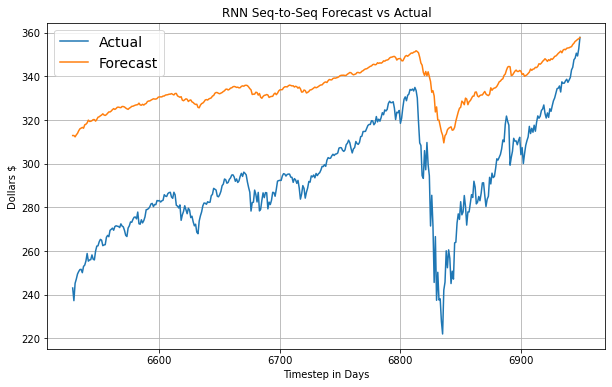

In [100]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('RNN Seq-to-Seq Forecast vs Actual')


In [101]:
# Alternative way to show MAE to stay consistent with what we will be doing later
rnn_mae = keras.metrics.mean_absolute_error(x_test, rnn_unscaled_forecast).numpy()

# Save to our dictionary of model mae scores
model_mae_scores['rnn_seqtoseq'] = rnn_mae
model_mae_scores

{'naive': 2.722772511848341,
 'SMA 20': 16.962856635071123,
 'SMA 5': 6.754151658767568,
 'ARIMA': 2.795754057940963,
 'linear_model': 37.513725,
 'rnn_seqtovec': 3008.7556,
 'rnn_seqtoseq': 41.524616}

## LSTM Model

#### Learning Rate Finder

In [102]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [103]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.Nadam(lr=1e-5)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
276/276 [==============================] - 3s 9ms/step - loss: 0.0109 - mae: 0.1198
Epoch 2/100
276/276 [==============================] - 2s 9ms/step - loss: 7.1192e-04 - mae: 0.0270
Epoch 3/100
276/276 [==============================] - 2s 9ms/step - loss: 4.6617e-04 - mae: 0.0222
Epoch 4/100
276/276 [==============================] - 2s 9ms/step - loss: 3.1456e-04 - mae: 0.0189
Epoch 5/100
276/276 [==============================] - 2s 9ms/step - loss: 2.2681e-04 - mae: 0.0165
Epoch 6/100
276/276 [==============================] - 2s 9ms/step - loss: 1.8071e-04 - mae: 0.0150
Epoch 7/100
276/276 [==============================] - 2s 9ms/step - loss: 1.5780e-04 - mae: 0.0139
Epoch 8/100
276/276 [==============================] - 2s 9ms/step - loss: 1.4623e-04 - mae: 0.0133
Epoch 9/100
276/276 [==============================] - 2s 9ms/step - loss: 1.3998e-04 - mae: 0.0128
Epoch 10/100
276/276 [==============================] - 2s 9ms/step - loss: 1.3628e-04 - mae: 0.0125
Epo

Epoch 83/100
276/276 [==============================] - 2s 9ms/step - loss: 0.1490 - mae: 0.2609
Epoch 84/100
276/276 [==============================] - 3s 9ms/step - loss: 0.0290 - mae: 0.1250
Epoch 85/100
276/276 [==============================] - 2s 9ms/step - loss: 0.0341 - mae: 0.1423
Epoch 86/100
276/276 [==============================] - 2s 9ms/step - loss: 0.0270 - mae: 0.1364
Epoch 87/100
276/276 [==============================] - 2s 9ms/step - loss: 0.0466 - mae: 0.1787
Epoch 88/100
276/276 [==============================] - 2s 9ms/step - loss: 0.0588 - mae: 0.2023
Epoch 89/100
276/276 [==============================] - 2s 9ms/step - loss: 0.0732 - mae: 0.2288
Epoch 90/100
276/276 [==============================] - 2s 9ms/step - loss: 0.0922 - mae: 0.2577
Epoch 91/100
276/276 [==============================] - 2s 9ms/step - loss: 0.1170 - mae: 0.3067
Epoch 92/100
276/276 [==============================] - 2s 9ms/step - loss: 0.2256 - mae: 0.5114
Epoch 93/100
276/276 [========

(1e-08, 1.0, 0.0, 0.01)

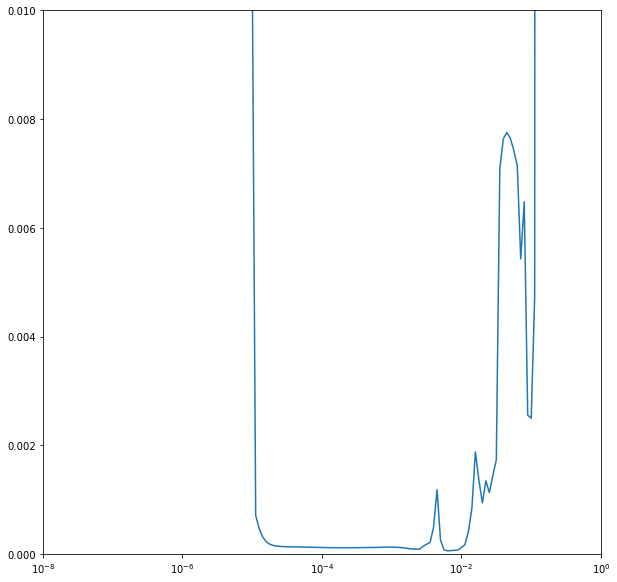

In [104]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1, 0, 0.01])

#### Train Model

In [105]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])
optimizer = keras.optimizers.Nadam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
276/276 [==============================] - 3s 11ms/step - loss: 1.7874e-04 - mae: 0.0134 - val_loss: 0.0064 - val_mae: 0.0829
Epoch 2/500
276/276 [==============================] - 2s 9ms/step - loss: 2.6411e-04 - mae: 0.0152 - val_loss: 0.0040 - val_mae: 0.0549
Epoch 3/500
276/276 [==============================] - 2s 9ms/step - loss: 1.5530e-04 - mae: 0.0126 - val_loss: 0.0033 - val_mae: 0.0447
Epoch 4/500
276/276 [==============================] - 2s 9ms/step - loss: 1.2480e-04 - mae: 0.0115 - val_loss: 0.0032 - val_mae: 0.0432
Epoch 5/500
276/276 [==============================] - 2s 9ms/step - loss: 1.1503e-04 - mae: 0.0110 - val_loss: 0.0031 - val_mae: 0.0435
Epoch 6/500
276/276 [==============================] - 2s 9ms/step - loss: 1.0940e-04 - mae: 0.0107 - val_loss: 0.0031 - val_mae: 0.0441
Epoch 7/500
276/276 [==============================] - 2s 9ms/step - loss: 1.0516e-04 - mae: 0.0105 - val_loss: 0.0031 - val_mae: 0.0448
Epoch 8/500
276/276 [===================

276/276 [==============================] - 2s 9ms/step - loss: 4.9044e-05 - mae: 0.0072 - val_loss: 0.0014 - val_mae: 0.0360
Epoch 61/500
276/276 [==============================] - 2s 9ms/step - loss: 4.8527e-05 - mae: 0.0072 - val_loss: 0.0014 - val_mae: 0.0356
Epoch 62/500
276/276 [==============================] - 2s 9ms/step - loss: 4.8008e-05 - mae: 0.0071 - val_loss: 0.0014 - val_mae: 0.0353
Epoch 63/500
276/276 [==============================] - 2s 9ms/step - loss: 4.7492e-05 - mae: 0.0071 - val_loss: 0.0013 - val_mae: 0.0351
Epoch 64/500
276/276 [==============================] - 2s 9ms/step - loss: 4.6984e-05 - mae: 0.0070 - val_loss: 0.0013 - val_mae: 0.0348
Epoch 65/500
276/276 [==============================] - 2s 9ms/step - loss: 4.6485e-05 - mae: 0.0070 - val_loss: 0.0013 - val_mae: 0.0346
Epoch 66/500
276/276 [==============================] - 2s 9ms/step - loss: 4.5998e-05 - mae: 0.0070 - val_loss: 0.0013 - val_mae: 0.0345
Epoch 67/500
276/276 [=========================

Epoch 119/500
276/276 [==============================] - 2s 9ms/step - loss: 3.2467e-05 - mae: 0.0057 - val_loss: 8.7233e-04 - val_mae: 0.0322
Epoch 120/500
276/276 [==============================] - 2s 9ms/step - loss: 3.2280e-05 - mae: 0.0057 - val_loss: 8.6889e-04 - val_mae: 0.0322
Epoch 121/500
276/276 [==============================] - 2s 9ms/step - loss: 3.2097e-05 - mae: 0.0057 - val_loss: 8.6533e-04 - val_mae: 0.0322
Epoch 122/500
276/276 [==============================] - 2s 9ms/step - loss: 3.1917e-05 - mae: 0.0057 - val_loss: 8.6156e-04 - val_mae: 0.0322
Epoch 123/500
276/276 [==============================] - 2s 9ms/step - loss: 3.1741e-05 - mae: 0.0057 - val_loss: 8.5753e-04 - val_mae: 0.0322
Epoch 124/500
276/276 [==============================] - 2s 9ms/step - loss: 3.1568e-05 - mae: 0.0057 - val_loss: 8.5320e-04 - val_mae: 0.0322
Epoch 125/500
276/276 [==============================] - 2s 9ms/step - loss: 3.1396e-05 - mae: 0.0056 - val_loss: 8.4850e-04 - val_mae: 0.0322

276/276 [==============================] - 2s 9ms/step - loss: 2.5560e-05 - mae: 0.0050 - val_loss: 5.9183e-04 - val_mae: 0.0280
Epoch 177/500
276/276 [==============================] - 2s 9ms/step - loss: 2.5469e-05 - mae: 0.0050 - val_loss: 5.8788e-04 - val_mae: 0.0280
Epoch 178/500
276/276 [==============================] - 2s 9ms/step - loss: 2.5378e-05 - mae: 0.0050 - val_loss: 5.8371e-04 - val_mae: 0.0279
Epoch 179/500
276/276 [==============================] - 2s 9ms/step - loss: 2.5288e-05 - mae: 0.0050 - val_loss: 5.7940e-04 - val_mae: 0.0278
Epoch 180/500
276/276 [==============================] - 2s 9ms/step - loss: 2.5199e-05 - mae: 0.0050 - val_loss: 5.7502e-04 - val_mae: 0.0277
Epoch 181/500
276/276 [==============================] - 2s 9ms/step - loss: 2.5110e-05 - mae: 0.0050 - val_loss: 5.7064e-04 - val_mae: 0.0276
Epoch 182/500
276/276 [==============================] - 2s 9ms/step - loss: 2.5024e-05 - mae: 0.0050 - val_loss: 5.6630e-04 - val_mae: 0.0276
Epoch 183/500

276/276 [==============================] - 2s 9ms/step - loss: 2.3212e-05 - mae: 0.0047 - val_loss: 4.6003e-04 - val_mae: 0.0253
Epoch 234/500
276/276 [==============================] - 2s 9ms/step - loss: 2.3163e-05 - mae: 0.0047 - val_loss: 4.5765e-04 - val_mae: 0.0252
Epoch 235/500
276/276 [==============================] - 2s 9ms/step - loss: 2.3113e-05 - mae: 0.0047 - val_loss: 4.5558e-04 - val_mae: 0.0252
Epoch 236/500
276/276 [==============================] - 2s 9ms/step - loss: 2.3064e-05 - mae: 0.0047 - val_loss: 4.5384e-04 - val_mae: 0.0251
Epoch 237/500
276/276 [==============================] - 2s 9ms/step - loss: 2.3015e-05 - mae: 0.0047 - val_loss: 4.5248e-04 - val_mae: 0.0251
Epoch 238/500
276/276 [==============================] - 2s 9ms/step - loss: 2.2968e-05 - mae: 0.0047 - val_loss: 4.5156e-04 - val_mae: 0.0251
Epoch 239/500
276/276 [==============================] - 2s 9ms/step - loss: 2.2923e-05 - mae: 0.0047 - val_loss: 4.5111e-04 - val_mae: 0.0251
Epoch 240/500

276/276 [==============================] - 2s 9ms/step - loss: 2.2209e-05 - mae: 0.0046 - val_loss: 4.5361e-04 - val_mae: 0.0255
Epoch 291/500
276/276 [==============================] - 2s 9ms/step - loss: 2.2207e-05 - mae: 0.0046 - val_loss: 4.5388e-04 - val_mae: 0.0255
Epoch 292/500
276/276 [==============================] - 2s 9ms/step - loss: 2.2203e-05 - mae: 0.0046 - val_loss: 4.5415e-04 - val_mae: 0.0255
Epoch 293/500
276/276 [==============================] - 2s 9ms/step - loss: 2.2197e-05 - mae: 0.0046 - val_loss: 4.5441e-04 - val_mae: 0.0255
Epoch 294/500
276/276 [==============================] - 2s 9ms/step - loss: 2.2191e-05 - mae: 0.0046 - val_loss: 4.5459e-04 - val_mae: 0.0255
Epoch 295/500
276/276 [==============================] - 2s 9ms/step - loss: 2.2183e-05 - mae: 0.0046 - val_loss: 4.5471e-04 - val_mae: 0.0255
Epoch 296/500
276/276 [==============================] - 2s 9ms/step - loss: 2.2174e-05 - mae: 0.0046 - val_loss: 4.5482e-04 - val_mae: 0.0255
Epoch 297/500

In [106]:
model = keras.models.load_model("my_checkpoint.h5")

#### Make Predictions and Evaluate

In [107]:
lstm_unscaled_forecast = model.predict(normalized_x_test[np.newaxis,:])
lstm_unscaled_forecast = lstm_unscaled_forecast.flatten()

In [108]:
# Example of how to iverse
lstm_unscaled_forecast = x_train_scaler.inverse_transform(lstm_unscaled_forecast.reshape(-1,1)).flatten()
lstm_unscaled_forecast.shape

(422,)

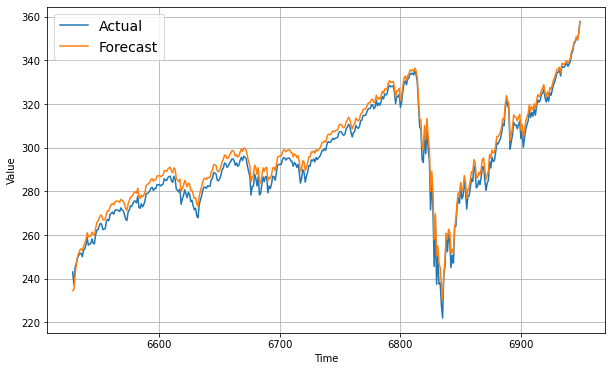

In [109]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, lstm_unscaled_forecast, label="Forecast")

In [110]:
lstm_mae = keras.metrics.mean_absolute_error(x_test, lstm_unscaled_forecast).numpy()
model_mae_scores['lstm'] = lstm_mae

In [131]:
model_mae_scores

{'naive': 2.722772511848341,
 'SMA 20': 16.962856635071123,
 'SMA 5': 6.754151658767568,
 'ARIMA': 2.795754057940963,
 'linear_model': 37.513725,
 'rnn_seqtovec': 3008.7556,
 'rnn_seqtoseq': 41.524616,
 'lstm': 3.585236,
 'cnn_preprocessing_rnn': 38.362865,
 'full_cnn': 37.910133}

## Preprocessing with 1-D CNN for RNN Model

#### Learning Rate Finder

In [111]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = keras.optimizers.Nadam(lr=1e-5)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
43/43 [==============================] - 1s 23ms/step - loss: 0.0884 - mae: 0.3625
Epoch 2/100
43/43 [==============================] - 1s 22ms/step - loss: 0.0836 - mae: 0.3510
Epoch 3/100
43/43 [==============================] - 1s 23ms/step - loss: 0.0789 - mae: 0.3399
Epoch 4/100
43/43 [==============================] - 1s 22ms/step - loss: 0.0739 - mae: 0.3278
Epoch 5/100
43/43 [==============================] - 1s 22ms/step - loss: 0.0684 - mae: 0.3142
Epoch 6/100
43/43 [==============================] - 1s 22ms/step - loss: 0.0622 - mae: 0.2982
Epoch 7/100
43/43 [==============================] - 1s 23ms/step - loss: 0.0552 - mae: 0.2788
Epoch 8/100
43/43 [==============================] - 1s 22ms/step - loss: 0.0475 - mae: 0.2553
Epoch 9/100
43/43 [==============================] - 1s 23ms/step - loss: 0.0395 - mae: 0.2270
Epoch 10/100
43/43 [==============================] - 1s 22ms/step - loss: 0.0321 - mae: 0.1951
Epoch 11/100
43/43 [=============================

43/43 [==============================] - 1s 23ms/step - loss: 0.0199 - mae: 0.1493
Epoch 86/100
43/43 [==============================] - 1s 23ms/step - loss: 0.0217 - mae: 0.1582
Epoch 87/100
43/43 [==============================] - 1s 23ms/step - loss: 0.0222 - mae: 0.1599
Epoch 88/100
43/43 [==============================] - 1s 23ms/step - loss: 0.0297 - mae: 0.1760
Epoch 89/100
43/43 [==============================] - 1s 23ms/step - loss: 0.0331 - mae: 0.1949
Epoch 90/100
43/43 [==============================] - 1s 22ms/step - loss: 0.0392 - mae: 0.2054
Epoch 91/100
43/43 [==============================] - 1s 23ms/step - loss: 0.0313 - mae: 0.1788
Epoch 92/100
43/43 [==============================] - 1s 23ms/step - loss: 0.0189 - mae: 0.1472
Epoch 93/100
43/43 [==============================] - 1s 23ms/step - loss: 0.0326 - mae: 0.1912
Epoch 94/100
43/43 [==============================] - 1s 23ms/step - loss: 0.0888 - mae: 0.3101
Epoch 95/100
43/43 [==============================] -

(1e-06, 1.0, 0.0, 0.1)

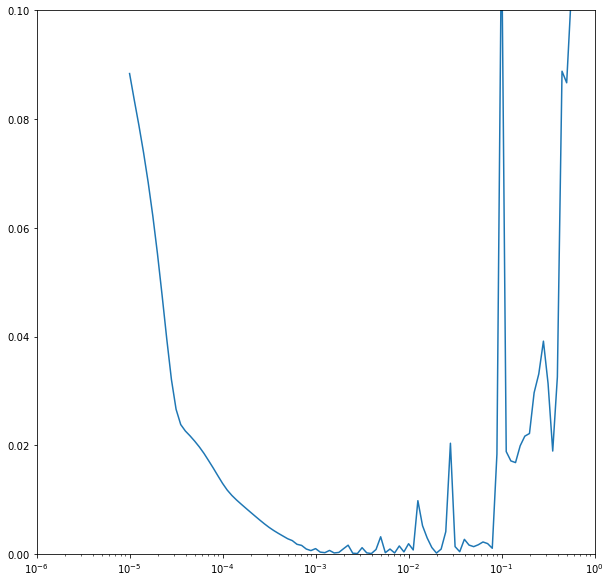

In [112]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1, 0, .1])

#### Train Model

In [113]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=512)
valid_set = seq2seq_window_dataset(normalized_x_valid, window_size,
                                   batch_size=512)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
])
optimizer = keras.optimizers.Nadam(lr=1e-3)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
11/11 [==============================] - 1s 109ms/step - loss: 0.0377 - mae: 0.2262 - val_loss: 0.0372 - val_mae: 0.2004
Epoch 2/500
11/11 [==============================] - 1s 65ms/step - loss: 0.0205 - mae: 0.1505 - val_loss: 0.0294 - val_mae: 0.1718
Epoch 3/500
11/11 [==============================] - 1s 65ms/step - loss: 0.0162 - mae: 0.1270 - val_loss: 0.0235 - val_mae: 0.1493
Epoch 4/500
11/11 [==============================] - 1s 65ms/step - loss: 0.0130 - mae: 0.1081 - val_loss: 0.0190 - val_mae: 0.1286
Epoch 5/500
11/11 [==============================] - 1s 64ms/step - loss: 0.0107 - mae: 0.0950 - val_loss: 0.0180 - val_mae: 0.1363
Epoch 6/500
11/11 [==============================] - 1s 65ms/step - loss: 0.0093 - mae: 0.0864 - val_loss: 0.0144 - val_mae: 0.1041
Epoch 7/500
11/11 [==============================] - 1s 64ms/step - loss: 0.0079 - mae: 0.0750 - val_loss: 0.0121 - val_mae: 0.0830
Epoch 8/500
11/11 [==============================] - 1s 65ms/step - loss: 0

11/11 [==============================] - 1s 62ms/step - loss: 1.2925e-04 - mae: 0.0107 - val_loss: 0.0029 - val_mae: 0.0619
Epoch 62/500
11/11 [==============================] - 1s 62ms/step - loss: 1.7144e-04 - mae: 0.0135 - val_loss: 3.3359e-04 - val_mae: 0.0202
Epoch 63/500
11/11 [==============================] - 1s 63ms/step - loss: 1.0586e-04 - mae: 0.0100 - val_loss: 0.0013 - val_mae: 0.0416
Epoch 64/500
11/11 [==============================] - 1s 64ms/step - loss: 1.1357e-04 - mae: 0.0107 - val_loss: 2.2968e-04 - val_mae: 0.0159
Epoch 65/500
11/11 [==============================] - 1s 63ms/step - loss: 1.0304e-04 - mae: 0.0096 - val_loss: 0.0021 - val_mae: 0.0520
Epoch 66/500
11/11 [==============================] - 1s 62ms/step - loss: 1.3030e-04 - mae: 0.0116 - val_loss: 2.7706e-04 - val_mae: 0.0177
Epoch 67/500
11/11 [==============================] - 1s 61ms/step - loss: 8.5417e-05 - mae: 0.0088 - val_loss: 7.0576e-04 - val_mae: 0.0305
Epoch 68/500
11/11 [==================

11/11 [==============================] - 1s 63ms/step - loss: 4.0052e-05 - mae: 0.0062 - val_loss: 1.8607e-04 - val_mae: 0.0145
Epoch 120/500
11/11 [==============================] - 1s 63ms/step - loss: 3.8406e-05 - mae: 0.0060 - val_loss: 1.7003e-04 - val_mae: 0.0124
Epoch 121/500
11/11 [==============================] - 1s 63ms/step - loss: 3.7638e-05 - mae: 0.0059 - val_loss: 1.8346e-04 - val_mae: 0.0144
Epoch 122/500
11/11 [==============================] - 1s 63ms/step - loss: 3.7898e-05 - mae: 0.0060 - val_loss: 1.8873e-04 - val_mae: 0.0146
Epoch 123/500
11/11 [==============================] - 1s 61ms/step - loss: 3.8214e-05 - mae: 0.0061 - val_loss: 2.2815e-04 - val_mae: 0.0152
Epoch 124/500
11/11 [==============================] - 1s 64ms/step - loss: 3.9295e-05 - mae: 0.0062 - val_loss: 2.4249e-04 - val_mae: 0.0176
Epoch 125/500
11/11 [==============================] - 1s 63ms/step - loss: 3.8796e-05 - mae: 0.0062 - val_loss: 1.5944e-04 - val_mae: 0.0125
Epoch 126/500
11/11 

11/11 [==============================] - 1s 63ms/step - loss: 6.9514e-05 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0397
Epoch 178/500
11/11 [==============================] - 1s 63ms/step - loss: 7.2648e-05 - mae: 0.0085 - val_loss: 1.6658e-04 - val_mae: 0.0125
Epoch 179/500
11/11 [==============================] - 1s 63ms/step - loss: 3.6320e-05 - mae: 0.0062 - val_loss: 1.5109e-04 - val_mae: 0.0122
Epoch 180/500
11/11 [==============================] - 1s 63ms/step - loss: 2.8904e-05 - mae: 0.0054 - val_loss: 1.5323e-04 - val_mae: 0.0117
Epoch 181/500
11/11 [==============================] - 1s 61ms/step - loss: 2.8497e-05 - mae: 0.0053 - val_loss: 1.6661e-04 - val_mae: 0.0135
Epoch 182/500
11/11 [==============================] - 1s 64ms/step - loss: 2.8692e-05 - mae: 0.0054 - val_loss: 1.4611e-04 - val_mae: 0.0115
Epoch 183/500
11/11 [==============================] - 1s 61ms/step - loss: 2.7885e-05 - mae: 0.0053 - val_loss: 1.5173e-04 - val_mae: 0.0123
Epoch 184/500
11/11 [===

Epoch 235/500
11/11 [==============================] - 1s 63ms/step - loss: 2.9999e-05 - mae: 0.0057 - val_loss: 2.8600e-04 - val_mae: 0.0180
Epoch 236/500
11/11 [==============================] - 1s 63ms/step - loss: 3.2327e-05 - mae: 0.0060 - val_loss: 5.6915e-04 - val_mae: 0.0265
Epoch 237/500
11/11 [==============================] - 1s 62ms/step - loss: 3.7340e-05 - mae: 0.0064 - val_loss: 4.2850e-04 - val_mae: 0.0223
Epoch 238/500
11/11 [==============================] - 1s 63ms/step - loss: 3.1589e-05 - mae: 0.0059 - val_loss: 2.6116e-04 - val_mae: 0.0164
Epoch 239/500
11/11 [==============================] - 1s 63ms/step - loss: 4.0489e-05 - mae: 0.0063 - val_loss: 0.0018 - val_mae: 0.0496
Epoch 240/500
11/11 [==============================] - 1s 63ms/step - loss: 1.2855e-04 - mae: 0.0113 - val_loss: 0.0076 - val_mae: 0.1028
Epoch 241/500
11/11 [==============================] - 1s 63ms/step - loss: 3.3582e-04 - mae: 0.0181 - val_loss: 0.0124 - val_mae: 0.1312
Epoch 242/500
11/1

Epoch 293/500
11/11 [==============================] - 1s 63ms/step - loss: 2.5166e-05 - mae: 0.0052 - val_loss: 1.5918e-04 - val_mae: 0.0132
Epoch 294/500
11/11 [==============================] - 1s 63ms/step - loss: 2.4202e-05 - mae: 0.0050 - val_loss: 1.5530e-04 - val_mae: 0.0129
Epoch 295/500
11/11 [==============================] - 1s 63ms/step - loss: 2.4153e-05 - mae: 0.0049 - val_loss: 2.3422e-04 - val_mae: 0.0173
Epoch 296/500
11/11 [==============================] - 1s 63ms/step - loss: 2.5722e-05 - mae: 0.0052 - val_loss: 1.4943e-04 - val_mae: 0.0117
Epoch 297/500
11/11 [==============================] - 1s 64ms/step - loss: 2.3587e-05 - mae: 0.0049 - val_loss: 2.1640e-04 - val_mae: 0.0148
Epoch 298/500
11/11 [==============================] - 1s 65ms/step - loss: 2.4400e-05 - mae: 0.0050 - val_loss: 1.3889e-04 - val_mae: 0.0111
Epoch 299/500
11/11 [==============================] - 1s 63ms/step - loss: 2.8820e-05 - mae: 0.0053 - val_loss: 7.7934e-04 - val_mae: 0.0329
Epoch 

Epoch 351/500
11/11 [==============================] - 1s 63ms/step - loss: 3.4240e-04 - mae: 0.0187 - val_loss: 0.0090 - val_mae: 0.1120
Epoch 352/500
11/11 [==============================] - 1s 63ms/step - loss: 2.5755e-04 - mae: 0.0165 - val_loss: 2.8984e-04 - val_mae: 0.0172
Epoch 353/500
11/11 [==============================] - 1s 63ms/step - loss: 3.4553e-05 - mae: 0.0062 - val_loss: 3.7800e-04 - val_mae: 0.0230
Epoch 354/500
11/11 [==============================] - 1s 63ms/step - loss: 4.1603e-05 - mae: 0.0068 - val_loss: 1.4046e-04 - val_mae: 0.0116
Epoch 355/500
11/11 [==============================] - 1s 64ms/step - loss: 2.4854e-05 - mae: 0.0051 - val_loss: 1.4131e-04 - val_mae: 0.0118
Epoch 356/500
11/11 [==============================] - 1s 62ms/step - loss: 2.3449e-05 - mae: 0.0049 - val_loss: 1.6924e-04 - val_mae: 0.0127
Epoch 357/500
11/11 [==============================] - 1s 62ms/step - loss: 2.3375e-05 - mae: 0.0049 - val_loss: 1.4135e-04 - val_mae: 0.0119
Epoch 358/

Epoch 409/500
11/11 [==============================] - 1s 64ms/step - loss: 4.5395e-05 - mae: 0.0073 - val_loss: 1.5404e-04 - val_mae: 0.0119
Epoch 410/500
11/11 [==============================] - 1s 63ms/step - loss: 2.7501e-05 - mae: 0.0051 - val_loss: 6.9789e-04 - val_mae: 0.0312
Epoch 411/500
11/11 [==============================] - 1s 63ms/step - loss: 4.4564e-05 - mae: 0.0069 - val_loss: 1.9055e-04 - val_mae: 0.0149
Epoch 412/500
11/11 [==============================] - 1s 63ms/step - loss: 2.2998e-05 - mae: 0.0048 - val_loss: 1.4022e-04 - val_mae: 0.0117
Epoch 413/500
11/11 [==============================] - 1s 63ms/step - loss: 2.1596e-05 - mae: 0.0046 - val_loss: 1.3885e-04 - val_mae: 0.0116
Epoch 414/500
11/11 [==============================] - 1s 64ms/step - loss: 2.1784e-05 - mae: 0.0046 - val_loss: 2.0522e-04 - val_mae: 0.0159
Epoch 415/500
11/11 [==============================] - 1s 63ms/step - loss: 2.4160e-05 - mae: 0.0050 - val_loss: 2.2278e-04 - val_mae: 0.0167
Epoch 

Epoch 467/500
11/11 [==============================] - 1s 64ms/step - loss: 2.0668e-05 - mae: 0.0044 - val_loss: 1.3455e-04 - val_mae: 0.0113
Epoch 468/500
11/11 [==============================] - 1s 61ms/step - loss: 2.0752e-05 - mae: 0.0045 - val_loss: 1.3696e-04 - val_mae: 0.0115
Epoch 469/500
11/11 [==============================] - 1s 62ms/step - loss: 2.2520e-05 - mae: 0.0046 - val_loss: 2.9198e-04 - val_mae: 0.0197
Epoch 470/500
11/11 [==============================] - 1s 63ms/step - loss: 2.6535e-05 - mae: 0.0053 - val_loss: 1.3461e-04 - val_mae: 0.0112
Epoch 471/500
11/11 [==============================] - 1s 63ms/step - loss: 2.0910e-05 - mae: 0.0045 - val_loss: 1.4966e-04 - val_mae: 0.0119
Epoch 472/500
11/11 [==============================] - 1s 62ms/step - loss: 2.1562e-05 - mae: 0.0046 - val_loss: 1.4881e-04 - val_mae: 0.0118
Epoch 473/500
11/11 [==============================] - 1s 61ms/step - loss: 2.1329e-05 - mae: 0.0045 - val_loss: 1.6011e-04 - val_mae: 0.0134
Epoch 

#### Make Predictions and Evaluate

In [114]:
model = keras.models.load_model("my_checkpoint.h5")

In [115]:
cnn_rnn_forecast = model_forecast(model, normalized_series[:,  np.newaxis], window_size)
cnn_rnn_forecast = cnn_rnn_forecast[x_test.index.min() - window_size:-1,-1,0]

In [116]:
cnn_rnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_rnn_forecast.reshape(-1,1)).flatten()
cnn_rnn_unscaled_forecast.shape

(422,)

In [117]:
cnn_rnn_mae = keras.metrics.mean_absolute_error(x_test, cnn_rnn_unscaled_forecast).numpy()
model_mae_scores['cnn_preprocessing_rnn'] = cnn_rnn_mae

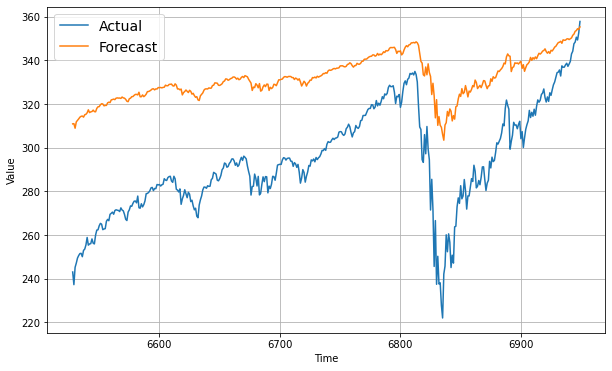

In [118]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label = 'Actual')
plot_series(x_test.index, cnn_rnn_unscaled_forecast, label = 'Forecast')

## CNN - Wavenet Model

### Learning Rate Finder

In [119]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Nadam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0801 - mae: 0.3453
Epoch 2/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0578 - mae: 0.2904
Epoch 3/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0255 - mae: 0.1873
Epoch 4/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0107 - mae: 0.1092
Epoch 5/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0086 - mae: 0.0989
Epoch 6/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0063 - mae: 0.0821
Epoch 7/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0043 - mae: 0.0657
Epoch 8/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0028 - mae: 0.0499
Epoch 9/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0016 - mae: 0.0344
Epoch 10/100
43/43 [==============================] - 1s 14ms/step - loss: 8.7664e-04 - mae: 0.0231
Epoch 11/100
43/43 [=========================

43/43 [==============================] - 1s 14ms/step - loss: 0.0205 - mae: 0.1584
Epoch 85/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0206 - mae: 0.1577
Epoch 86/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0200 - mae: 0.1560
Epoch 87/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0195 - mae: 0.1533
Epoch 88/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0194 - mae: 0.1517
Epoch 89/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0190 - mae: 0.1505
Epoch 90/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0186 - mae: 0.1485
Epoch 91/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0183 - mae: 0.1456
Epoch 92/100
43/43 [==============================] - 1s 14ms/step - loss: 0.0177 - mae: 0.1445
Epoch 93/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0179 - mae: 0.1447
Epoch 94/100
43/43 [==============================] -

(0.0001, 0.1, 0.0, 0.1)

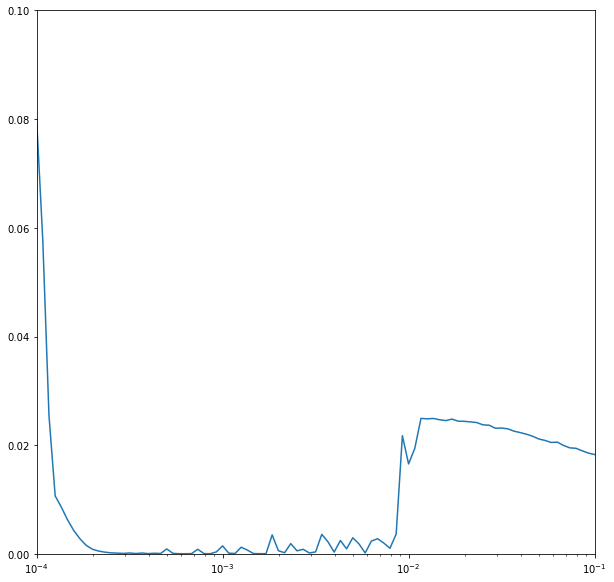

In [120]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, .1])

### Train Model

In [121]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(normalized_x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Nadam(lr=2e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
43/43 [==============================] - 1s 22ms/step - loss: 0.0532 - mae: 0.2830 - val_loss: 0.0499 - val_mae: 0.2339
Epoch 2/500
43/43 [==============================] - 1s 18ms/step - loss: 0.0130 - mae: 0.1250 - val_loss: 0.0208 - val_mae: 0.1629
Epoch 3/500
43/43 [==============================] - 1s 18ms/step - loss: 0.0104 - mae: 0.1101 - val_loss: 0.0145 - val_mae: 0.1372
Epoch 4/500
43/43 [==============================] - 1s 17ms/step - loss: 0.0068 - mae: 0.0877 - val_loss: 0.0090 - val_mae: 0.1090
Epoch 5/500
43/43 [==============================] - 1s 18ms/step - loss: 0.0038 - mae: 0.0637 - val_loss: 0.0043 - val_mae: 0.0704
Epoch 6/500
43/43 [==============================] - 1s 17ms/step - loss: 0.0017 - mae: 0.0380 - val_loss: 0.0021 - val_mae: 0.0431
Epoch 7/500
43/43 [==============================] - 1s 17ms/step - loss: 9.4287e-04 - mae: 0.0279 - val_loss: 0.0013 - val_mae: 0.0348
Epoch 8/500
43/43 [==============================] - 1s 17ms/step - loss

43/43 [==============================] - 1s 17ms/step - loss: 6.5194e-05 - mae: 0.0072 - val_loss: 0.0012 - val_mae: 0.0428
Epoch 60/500
43/43 [==============================] - 1s 17ms/step - loss: 4.3058e-05 - mae: 0.0070 - val_loss: 2.1248e-04 - val_mae: 0.0156
Epoch 61/500
43/43 [==============================] - 1s 17ms/step - loss: 3.0413e-05 - mae: 0.0056 - val_loss: 2.6358e-04 - val_mae: 0.0184
Epoch 62/500
43/43 [==============================] - 1s 17ms/step - loss: 2.7299e-05 - mae: 0.0054 - val_loss: 2.0082e-04 - val_mae: 0.0133
Epoch 63/500
43/43 [==============================] - 1s 17ms/step - loss: 2.9105e-05 - mae: 0.0054 - val_loss: 2.7258e-04 - val_mae: 0.0189
Epoch 64/500
43/43 [==============================] - 1s 17ms/step - loss: 2.7952e-05 - mae: 0.0054 - val_loss: 2.1126e-04 - val_mae: 0.0156
Epoch 65/500
43/43 [==============================] - 1s 17ms/step - loss: 2.6575e-05 - mae: 0.0052 - val_loss: 2.0736e-04 - val_mae: 0.0154
Epoch 66/500
43/43 [==========

43/43 [==============================] - 1s 17ms/step - loss: 3.5179e-05 - mae: 0.0063 - val_loss: 2.3250e-04 - val_mae: 0.0173
Epoch 118/500
43/43 [==============================] - 1s 17ms/step - loss: 6.1522e-05 - mae: 0.0071 - val_loss: 0.0010 - val_mae: 0.0379
Epoch 119/500
43/43 [==============================] - 1s 17ms/step - loss: 3.7461e-05 - mae: 0.0065 - val_loss: 1.6294e-04 - val_mae: 0.0119
Epoch 120/500
43/43 [==============================] - 1s 17ms/step - loss: 2.2889e-05 - mae: 0.0048 - val_loss: 1.5633e-04 - val_mae: 0.0119
Epoch 121/500
43/43 [==============================] - 1s 17ms/step - loss: 2.6499e-05 - mae: 0.0050 - val_loss: 2.7359e-04 - val_mae: 0.0193
Epoch 122/500
43/43 [==============================] - 1s 17ms/step - loss: 3.3864e-05 - mae: 0.0059 - val_loss: 3.4526e-04 - val_mae: 0.0198
Epoch 123/500
43/43 [==============================] - 1s 17ms/step - loss: 2.9861e-05 - mae: 0.0056 - val_loss: 2.5660e-04 - val_mae: 0.0184
Epoch 124/500
43/43 [===

Epoch 175/500
43/43 [==============================] - 1s 17ms/step - loss: 2.3241e-05 - mae: 0.0048 - val_loss: 2.0631e-04 - val_mae: 0.0143
Epoch 176/500
43/43 [==============================] - 1s 17ms/step - loss: 2.3168e-05 - mae: 0.0049 - val_loss: 1.7988e-04 - val_mae: 0.0129
Epoch 177/500
43/43 [==============================] - 1s 17ms/step - loss: 2.3594e-05 - mae: 0.0048 - val_loss: 2.1268e-04 - val_mae: 0.0164
Epoch 178/500
43/43 [==============================] - 1s 17ms/step - loss: 4.0650e-05 - mae: 0.0060 - val_loss: 6.2728e-04 - val_mae: 0.0293
Epoch 179/500
43/43 [==============================] - 1s 17ms/step - loss: 3.0661e-05 - mae: 0.0058 - val_loss: 1.5459e-04 - val_mae: 0.0116
Epoch 180/500
43/43 [==============================] - 1s 17ms/step - loss: 2.5892e-05 - mae: 0.0051 - val_loss: 2.3620e-04 - val_mae: 0.0177
Epoch 181/500
43/43 [==============================] - 1s 17ms/step - loss: 2.3667e-05 - mae: 0.0050 - val_loss: 1.6657e-04 - val_mae: 0.0124
Epoch 

Epoch 233/500
43/43 [==============================] - 1s 17ms/step - loss: 2.1265e-05 - mae: 0.0045 - val_loss: 1.5633e-04 - val_mae: 0.0131
Epoch 234/500
43/43 [==============================] - 1s 16ms/step - loss: 2.3100e-05 - mae: 0.0047 - val_loss: 2.8552e-04 - val_mae: 0.0199
Epoch 235/500
43/43 [==============================] - 1s 16ms/step - loss: 3.5821e-05 - mae: 0.0059 - val_loss: 6.6345e-04 - val_mae: 0.0318
Epoch 236/500
43/43 [==============================] - 1s 16ms/step - loss: 3.2544e-05 - mae: 0.0061 - val_loss: 1.4566e-04 - val_mae: 0.0121
Epoch 237/500
43/43 [==============================] - 1s 17ms/step - loss: 2.2103e-05 - mae: 0.0048 - val_loss: 1.3881e-04 - val_mae: 0.0111
Epoch 238/500
43/43 [==============================] - 1s 17ms/step - loss: 2.0783e-05 - mae: 0.0045 - val_loss: 1.4930e-04 - val_mae: 0.0125
Epoch 239/500
43/43 [==============================] - 1s 16ms/step - loss: 2.4232e-05 - mae: 0.0048 - val_loss: 2.5709e-04 - val_mae: 0.0187
Epoch 

Epoch 291/500
43/43 [==============================] - 1s 17ms/step - loss: 2.2896e-05 - mae: 0.0048 - val_loss: 1.8105e-04 - val_mae: 0.0149
Epoch 292/500
43/43 [==============================] - 1s 17ms/step - loss: 2.2685e-05 - mae: 0.0048 - val_loss: 1.6967e-04 - val_mae: 0.0129
Epoch 293/500
43/43 [==============================] - 1s 17ms/step - loss: 2.2753e-05 - mae: 0.0048 - val_loss: 1.7446e-04 - val_mae: 0.0144
Epoch 294/500
43/43 [==============================] - 1s 17ms/step - loss: 2.3496e-05 - mae: 0.0049 - val_loss: 1.8880e-04 - val_mae: 0.0139
Epoch 295/500
43/43 [==============================] - 1s 17ms/step - loss: 2.1414e-05 - mae: 0.0046 - val_loss: 1.3624e-04 - val_mae: 0.0113
Epoch 296/500
43/43 [==============================] - 1s 17ms/step - loss: 2.2652e-05 - mae: 0.0047 - val_loss: 1.9514e-04 - val_mae: 0.0156
Epoch 297/500
43/43 [==============================] - 1s 17ms/step - loss: 2.2344e-05 - mae: 0.0048 - val_loss: 1.6749e-04 - val_mae: 0.0128
Epoch 

Epoch 349/500
43/43 [==============================] - 1s 17ms/step - loss: 2.3936e-05 - mae: 0.0050 - val_loss: 1.3995e-04 - val_mae: 0.0112
Epoch 350/500
43/43 [==============================] - 1s 17ms/step - loss: 2.0748e-05 - mae: 0.0045 - val_loss: 1.4295e-04 - val_mae: 0.0114
Epoch 351/500
43/43 [==============================] - 1s 17ms/step - loss: 2.1608e-05 - mae: 0.0046 - val_loss: 1.6282e-04 - val_mae: 0.0125
Epoch 352/500
43/43 [==============================] - 1s 17ms/step - loss: 2.1584e-05 - mae: 0.0046 - val_loss: 1.5336e-04 - val_mae: 0.0129
Epoch 353/500
43/43 [==============================] - 1s 17ms/step - loss: 2.0512e-05 - mae: 0.0045 - val_loss: 1.3273e-04 - val_mae: 0.0109
Epoch 354/500
43/43 [==============================] - 1s 17ms/step - loss: 2.0651e-05 - mae: 0.0044 - val_loss: 1.6664e-04 - val_mae: 0.0127
Epoch 355/500
43/43 [==============================] - 1s 17ms/step - loss: 2.0942e-05 - mae: 0.0046 - val_loss: 1.4787e-04 - val_mae: 0.0117
Epoch 

Epoch 407/500
43/43 [==============================] - 1s 17ms/step - loss: 2.4437e-05 - mae: 0.0052 - val_loss: 1.3915e-04 - val_mae: 0.0118
Epoch 408/500
43/43 [==============================] - 1s 17ms/step - loss: 2.5718e-05 - mae: 0.0050 - val_loss: 2.8097e-04 - val_mae: 0.0197
Epoch 409/500
43/43 [==============================] - 1s 17ms/step - loss: 2.8545e-05 - mae: 0.0056 - val_loss: 1.9900e-04 - val_mae: 0.0145
Epoch 410/500
43/43 [==============================] - 1s 17ms/step - loss: 2.2624e-05 - mae: 0.0049 - val_loss: 1.3125e-04 - val_mae: 0.0110
Epoch 411/500
43/43 [==============================] - 1s 17ms/step - loss: 2.5566e-05 - mae: 0.0049 - val_loss: 2.1995e-04 - val_mae: 0.0170
Epoch 412/500
43/43 [==============================] - 1s 17ms/step - loss: 2.2797e-05 - mae: 0.0049 - val_loss: 1.3054e-04 - val_mae: 0.0108
Epoch 413/500
43/43 [==============================] - 1s 17ms/step - loss: 2.0237e-05 - mae: 0.0044 - val_loss: 1.3556e-04 - val_mae: 0.0110
Epoch 

Epoch 465/500
43/43 [==============================] - 1s 17ms/step - loss: 2.0272e-05 - mae: 0.0045 - val_loss: 1.3046e-04 - val_mae: 0.0110
Epoch 466/500
43/43 [==============================] - 1s 17ms/step - loss: 1.9861e-05 - mae: 0.0043 - val_loss: 1.3353e-04 - val_mae: 0.0114
Epoch 467/500
43/43 [==============================] - 1s 17ms/step - loss: 2.3098e-05 - mae: 0.0046 - val_loss: 2.2298e-04 - val_mae: 0.0156
Epoch 468/500
43/43 [==============================] - 1s 17ms/step - loss: 2.4205e-05 - mae: 0.0051 - val_loss: 1.6099e-04 - val_mae: 0.0125
Epoch 469/500
43/43 [==============================] - 1s 17ms/step - loss: 2.0795e-05 - mae: 0.0046 - val_loss: 1.3192e-04 - val_mae: 0.0108
Epoch 470/500
43/43 [==============================] - 1s 17ms/step - loss: 2.0727e-05 - mae: 0.0044 - val_loss: 1.5626e-04 - val_mae: 0.0133
Epoch 471/500
43/43 [==============================] - 1s 17ms/step - loss: 2.0494e-05 - mae: 0.0045 - val_loss: 1.3112e-04 - val_mae: 0.0111
Epoch 

### Make Predictions and Evaluate

In [122]:
model = keras.models.load_model("my_checkpoint.h5")

In [123]:
cnn_forecast = model_forecast(model, normalized_series[:,  np.newaxis], window_size)
cnn_forecast = cnn_forecast[x_test.index.min() - window_size:-1,-1,0]

In [124]:
cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()
cnn_unscaled_forecast.shape

(422,)

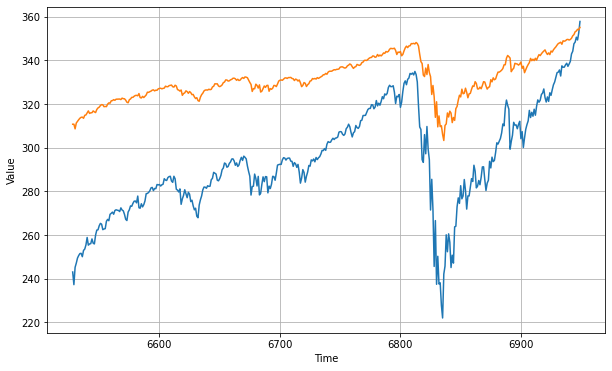

In [125]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test)
plot_series(x_test.index, cnn_unscaled_forecast)

In [126]:
full_cnn = keras.metrics.mean_absolute_error(x_test, cnn_unscaled_forecast).numpy()
model_mae_scores['full_cnn'] = full_cnn


# Summary of Model Results

In [127]:
# Store MAE scores
%store model_mae_scores

Stored 'model_mae_scores' (dict)


In [128]:
%store -r model_mae_scores
mae_series = pd.Series(model_mae_scores)
model_mae_scores

{'naive': 2.722772511848341,
 'SMA 20': 16.962856635071123,
 'SMA 5': 6.754151658767568,
 'ARIMA': 2.795754057940963,
 'linear_model': 37.513725,
 'rnn_seqtovec': 3008.7556,
 'rnn_seqtoseq': 41.524616,
 'lstm': 3.585236,
 'cnn_preprocessing_rnn': 38.362865,
 'full_cnn': 37.910133}

In [129]:
# Sort vales for clean bar chart
order = mae_series.sort_values()

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

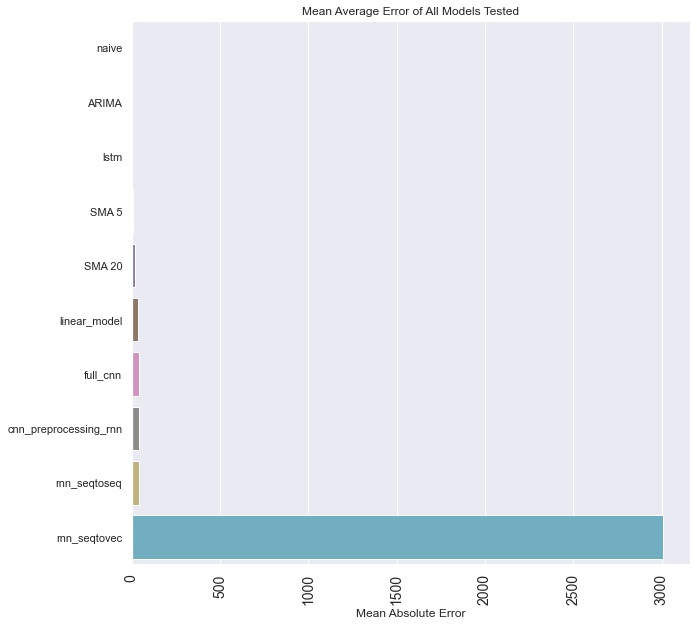

In [130]:
# Create bar chart for to show MAE of all models side by side
sns.set(style="darkgrid")
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')
